# Bohn Jour
___

In [1]:
from __future__ import unicode_literals
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import datetime
import common.chat
import common.live
import common.videos

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/live'
VIDEO_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/video'

#dates
bohnJour1Date = datetime.date(2015, 8, 1)
bohnJour2Date = datetime.date(2016, 6, 7)
youtubeAraDate = datetime.date(2016, 9, 1)

#colors
bohnJour1Color = '#66a1ff'
bohnJour2TwitchColor = '#ff6666'
bohnJour2YoutubeColor = '#ff8766'

#legend
bohnJour1Legend = mpatches.Patch(color=bohnJour1Color, label='Bohn Jour Staffel 1')
bohnJour2TwitchLegend = mpatches.Patch(color=bohnJour2TwitchColor, label='Bohn Jour Staffel 2 (Twitch)')
bohnJour2YoutubeLegend = mpatches.Patch(color=bohnJour2YoutubeColor, label='Bohn Jour Staffel 2 (Youtube)')

In [3]:
#load chat data
chat = common.chat.load(CHAT_DATA_DIRECTORY)

In [4]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

In [5]:
#load video data
videos, videosHosts, videosShows = common.videos.load(VIDEO_DATA_DIRECTORY)

#create additional column
videos['aired'] = videos['title'].str.extract('(\d{1,2}\.\d{1,2}\.\d{2,4})')

## Auswertung
___

In [6]:
#filter by show
show = 'Bohn Jour'
videoIds = videosShows[videosShows['show'] == show].index.unique().tolist()
videosFiltered = videos[videos.index.isin(videoIds)]

#filter by date
videosFiltered = videosFiltered[videosFiltered['published'] > bohnJour1Date]

#create additional column
videosFiltered['part'] = videosFiltered['title'].str.extract('(\d)\/\d')
videosFiltered['ratings_total'] = videosFiltered['likeCount'] + videosFiltered['dislikeCount']
videosFiltered['ratings_ratio'] = 100 * videosFiltered['likeCount'] / videosFiltered['ratings_total']

#sort
videosFiltered = videosFiltered.sort_values('published')

#group videos by aired
videosGrouped = videosFiltered.groupby('aired', sort=False)

videosFiltered

,title,channel,length,published,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,aired,part,ratings_total,ratings_ratio
id,,,,,,,,,,,,,
gBXRThTRv9o,gamescom 2015 | Bohn Jour mit Fabian Siegismu...,Rocket Beans TV,00:21:37,2015-08-05 23:23:05,46400,1480,21,0,123,05.08.2015,1,1501,98.600933
aEFWLT3kgrk,gamescom 2015 | Bohn Jour mit Lasertag-Action ...,Rocket Beans TV,00:19:41,2015-08-06 00:00:03,31186,908,9,0,77,05.08.2015,2,917,99.018539
W9s7TooZQpM,gamescom 2015 | Bohn Jour mit dem Termincrash ...,Rocket Beans TV,00:28:05,2015-08-06 02:27:36,32806,954,17,0,115,05.08.2015,3,971,98.249228
2NrOW8hdlMo,[1/3] Bohn Jour #30 | Das gamescom 2015 - Reca...,Rocket Beans TV,00:30:31,2015-08-13 20:00:00,36009,1008,24,0,112,12.08.2015,1,1032,97.674419
RGlAusLf4CA,[2/3] Bohn Jour #30 | Dosenbeatz auf der XMG-P...,Rocket Beans TV,00:32:53,2015-08-13 20:30:00,30491,735,24,0,53,12.08.2015,2,759,96.837945
21BpTpfoVb4,[3/3] Bohn Jour #30 | Rocket Beans gefesselt v...,Rocket Beans TV,00:38:14,2015-08-13 21:00:00,28065,784,16,0,77,12.08.2015,3,800,98.000000
e9HOqxL9sSk,"[1/3] Bohn Jour #31 | Highlights der Woche, ne...",Rocket Beans TV,00:30:48,2015-08-27 20:00:02,30681,991,17,0,160,26.08.2015,1,1008,98.313492
em33s75XAJ8,[2/3] Bohn Jour #31 | mit den Huck Bros als Gä...,Rocket Beans TV,00:22:58,2015-08-27 20:30:00,19806,582,8,0,36,26.08.2015,2,590,98.644068
-9eWfrsvqcQ,"[3/3] Bohn Jour #31 | Mate Knights mit Nils, S...",Rocket Beans TV,00:38:15,2015-08-27 21:29:40,25877,834,11,0,100,26.08.2015,3,845,98.698225


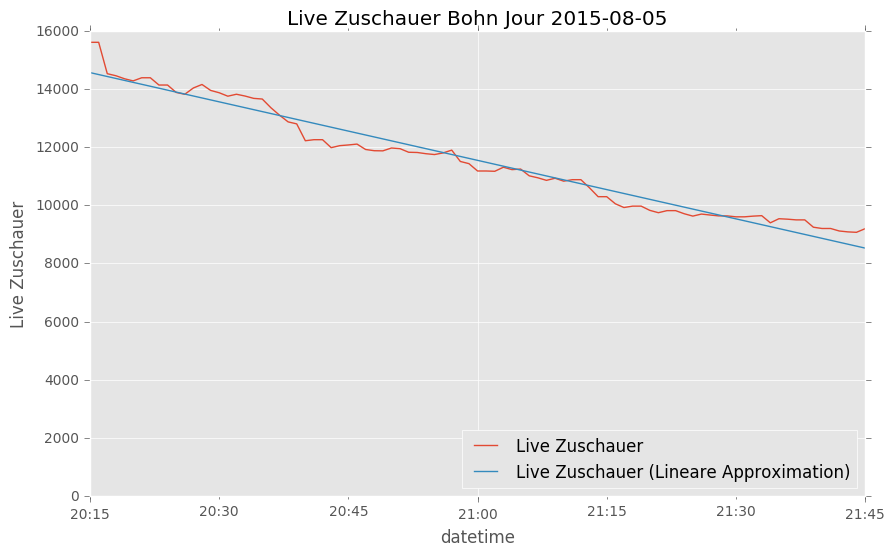

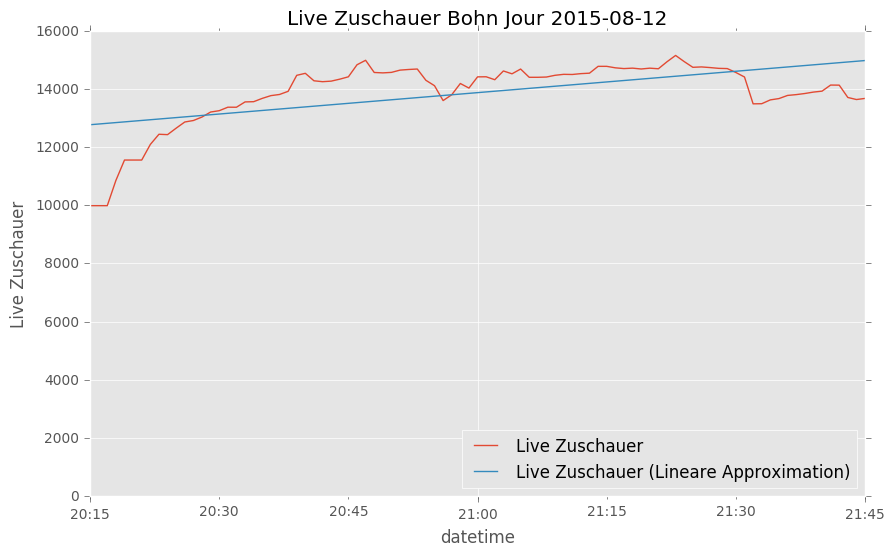

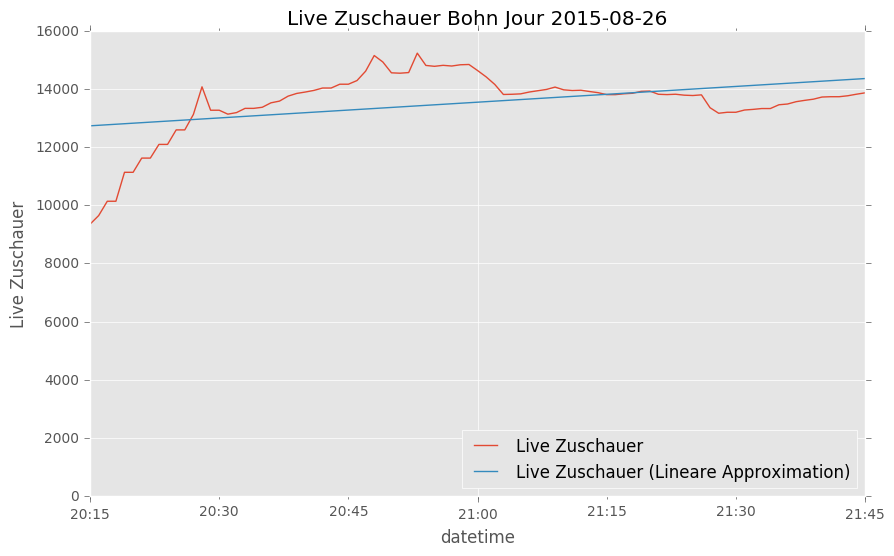

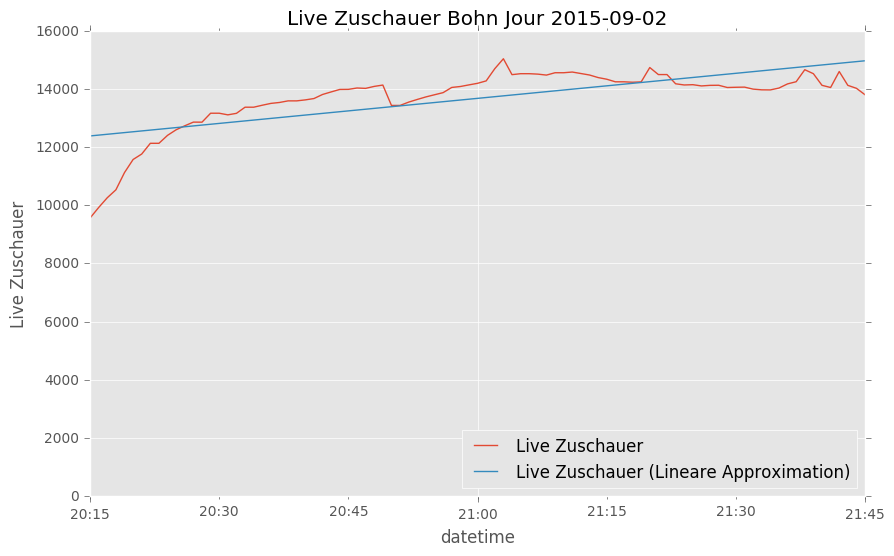

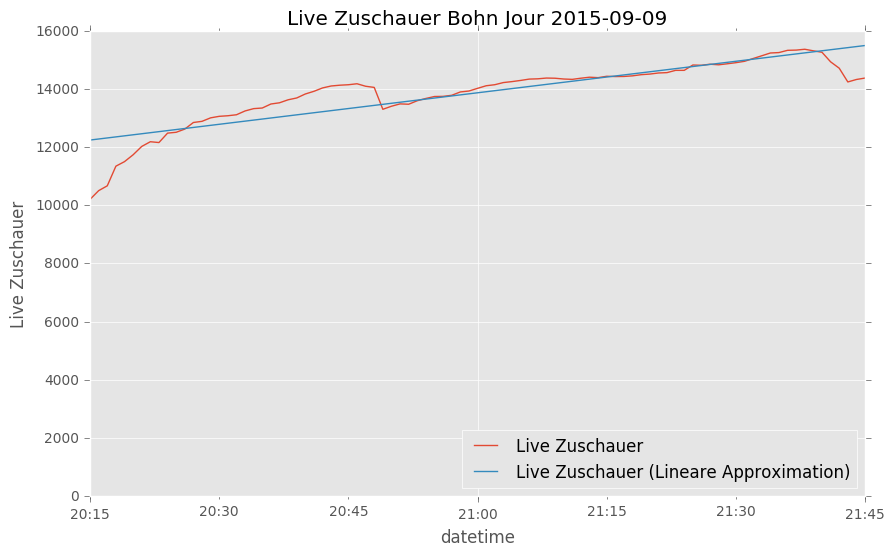

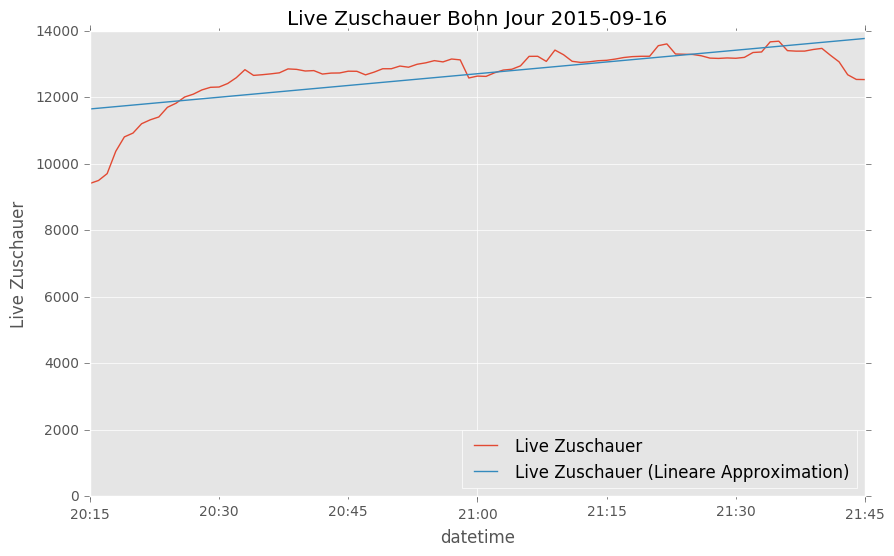

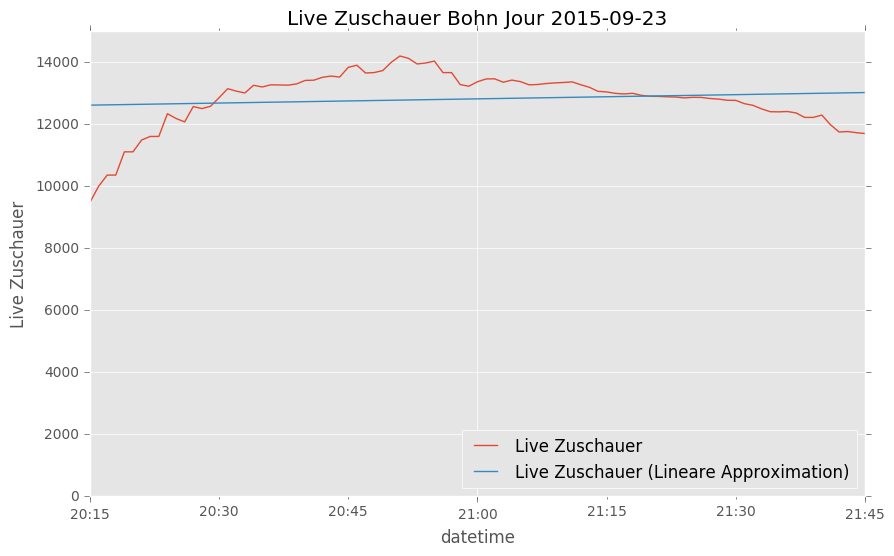

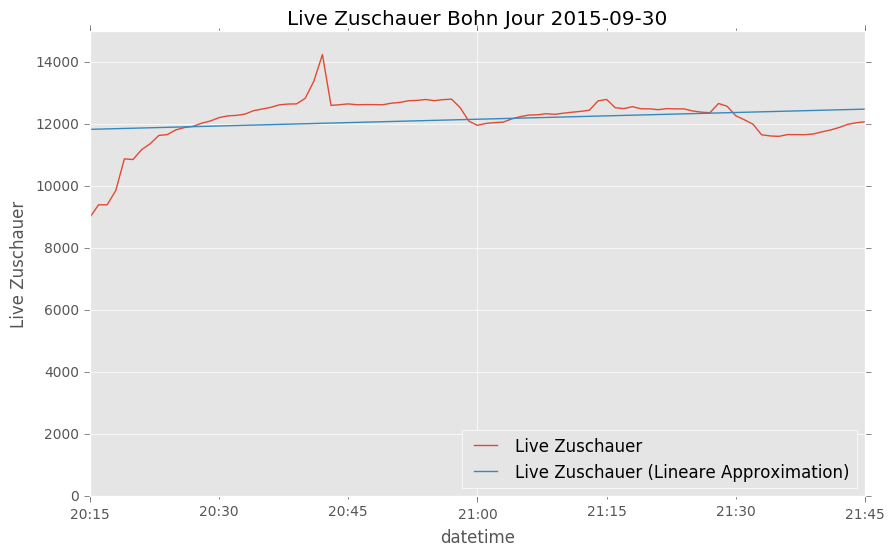

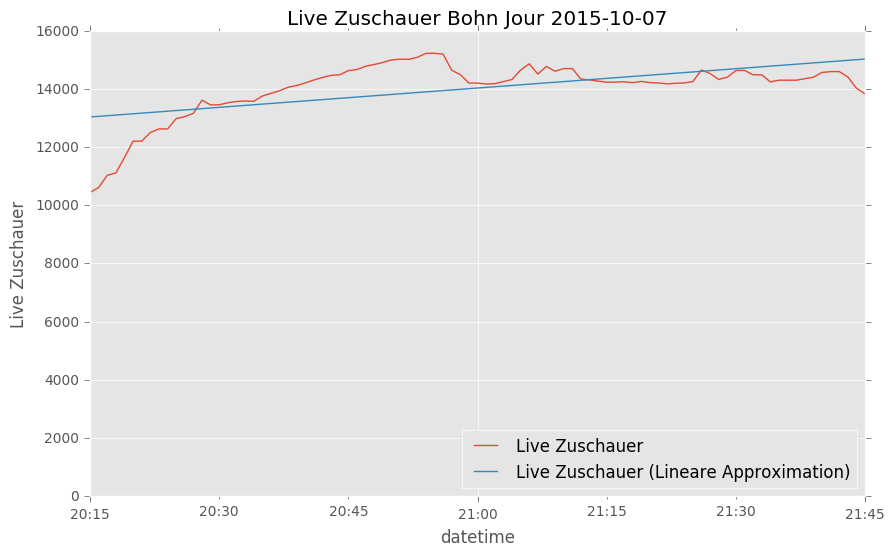

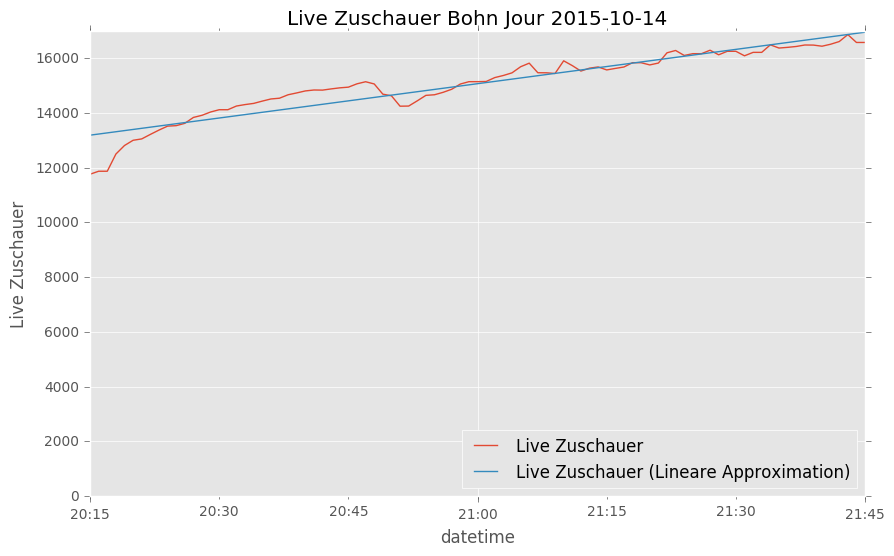

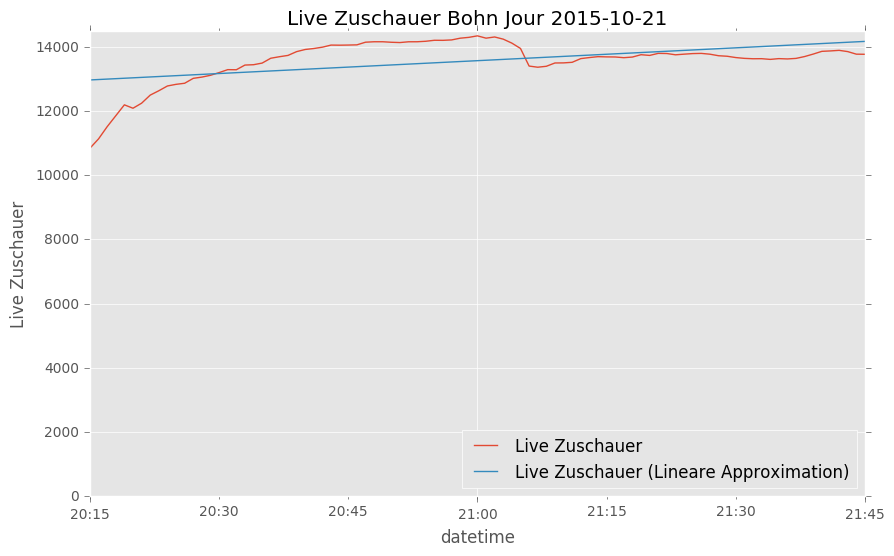

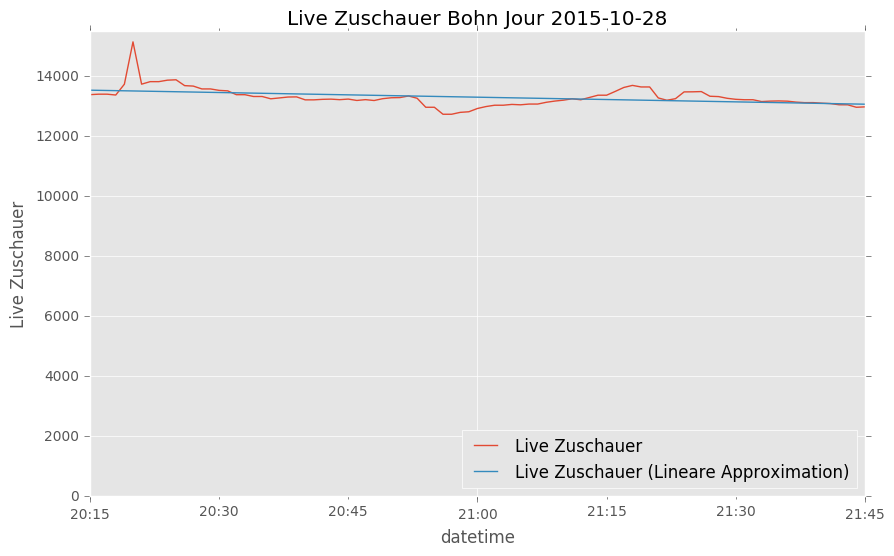

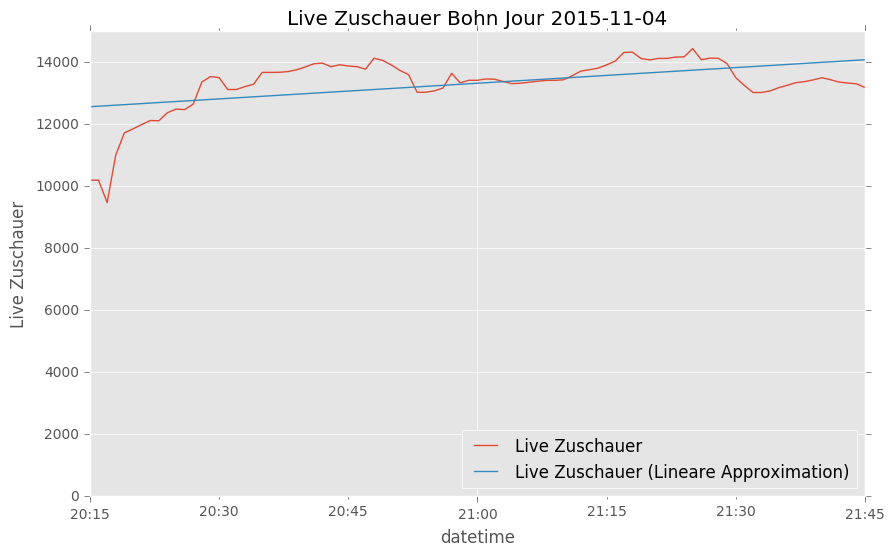

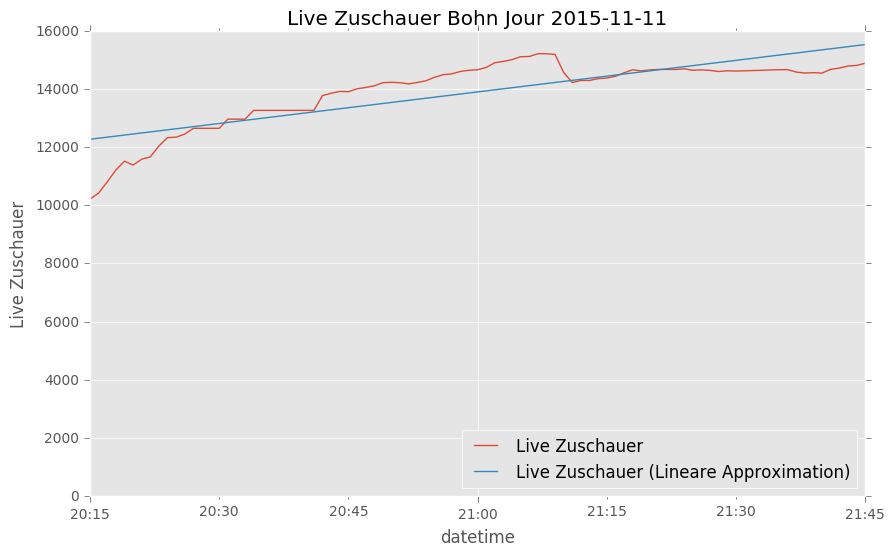

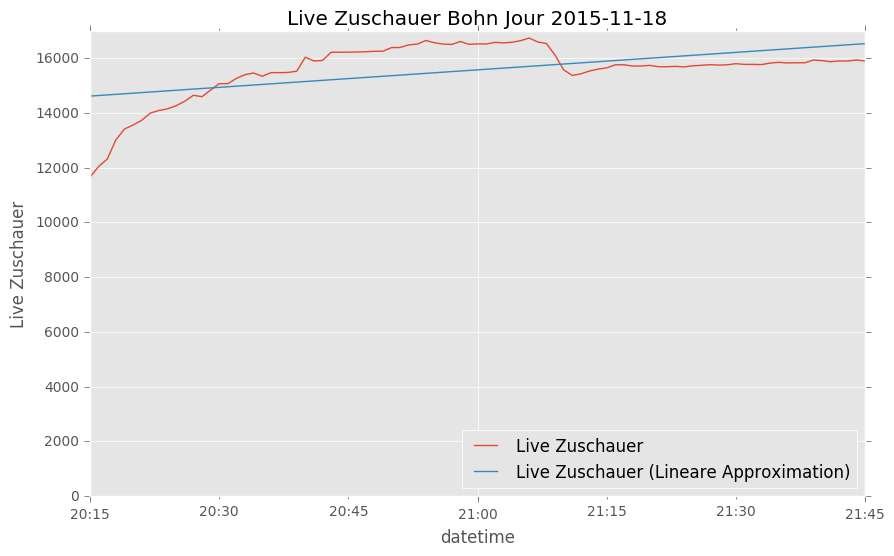

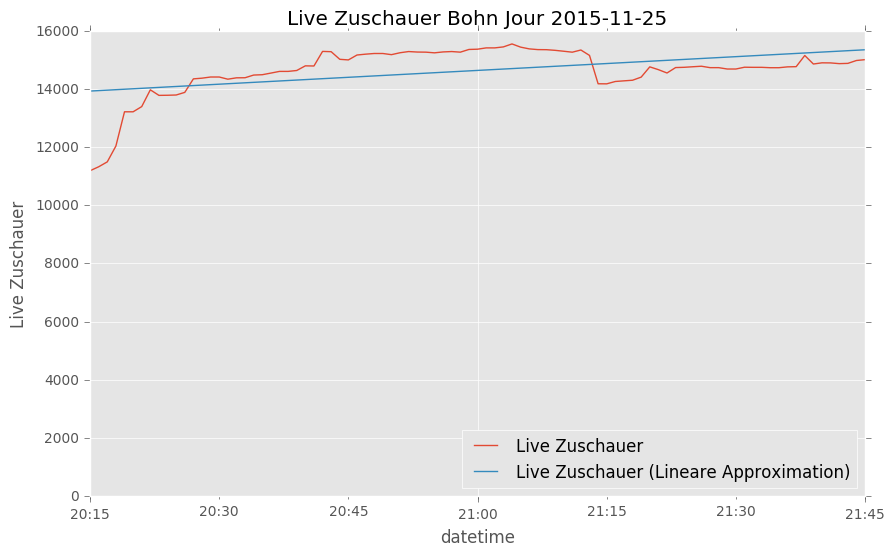

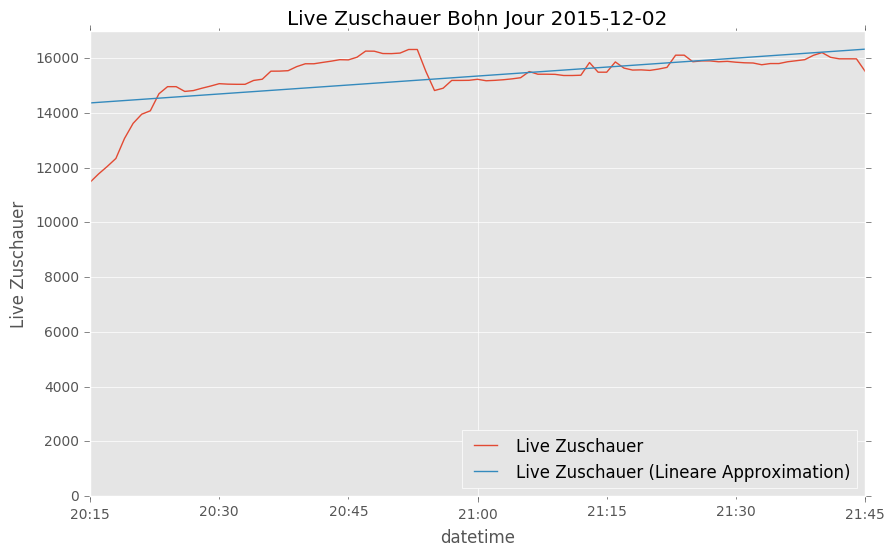

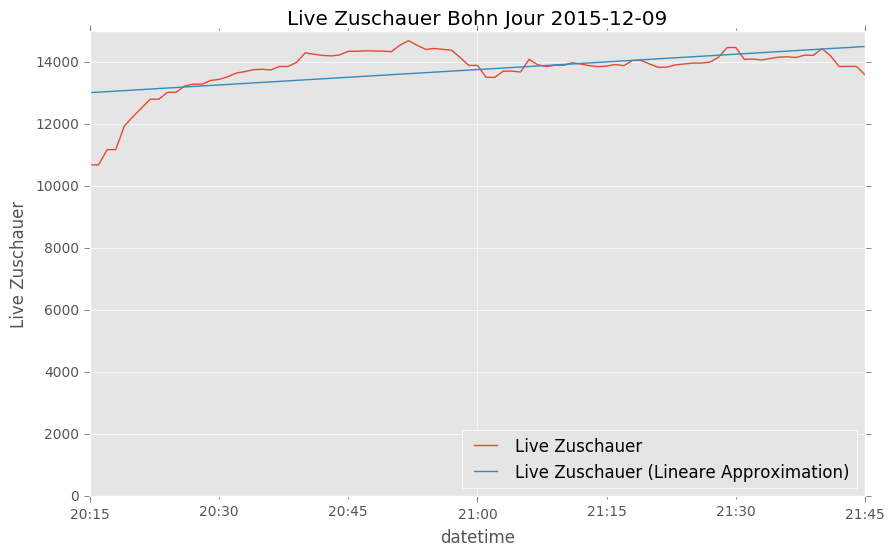

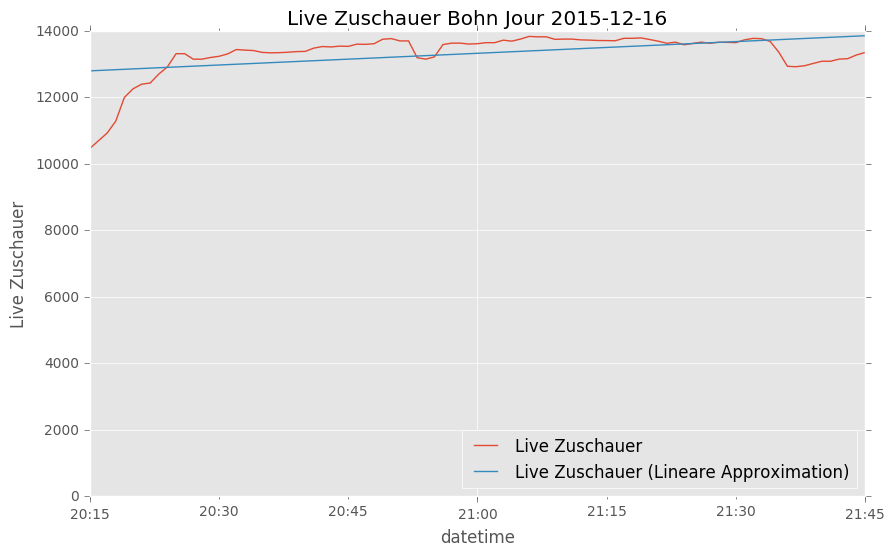

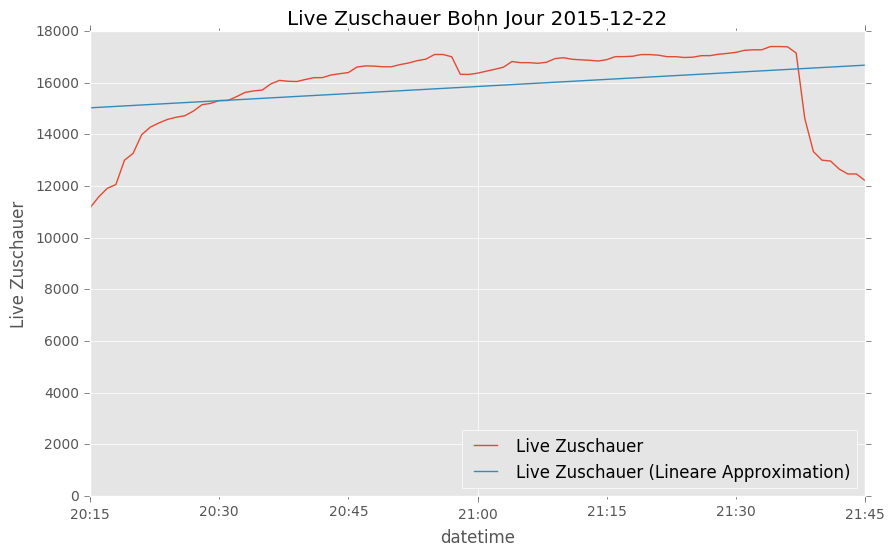

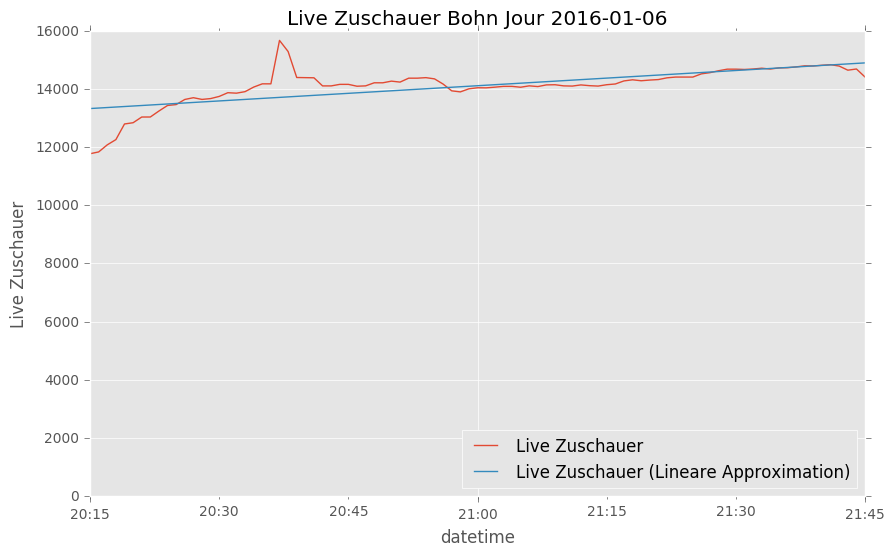

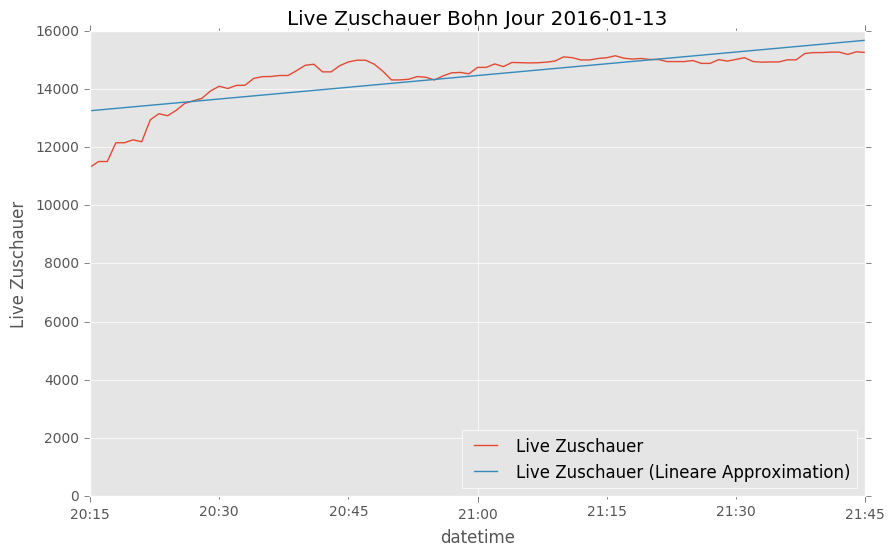

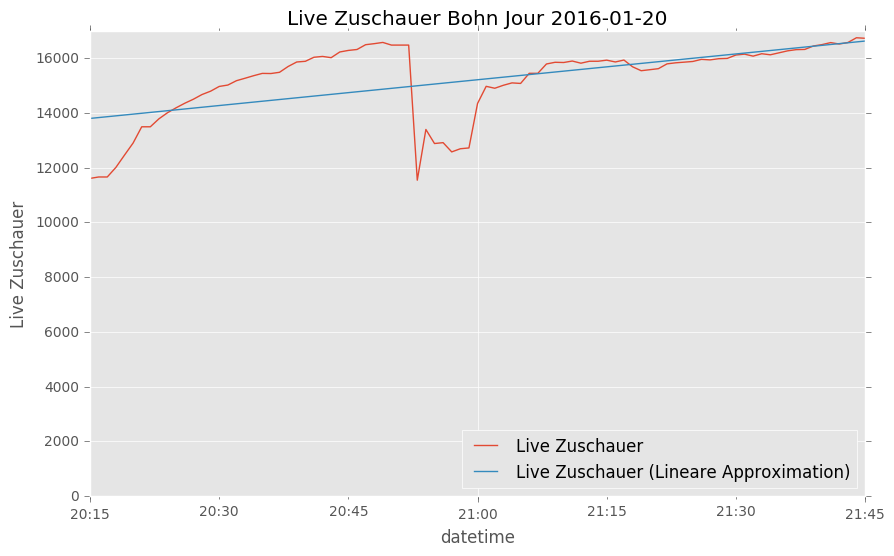

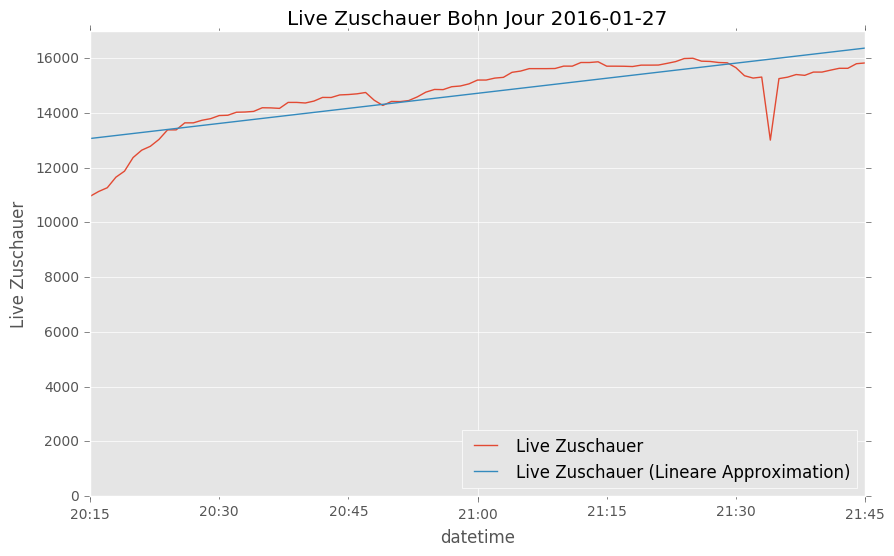

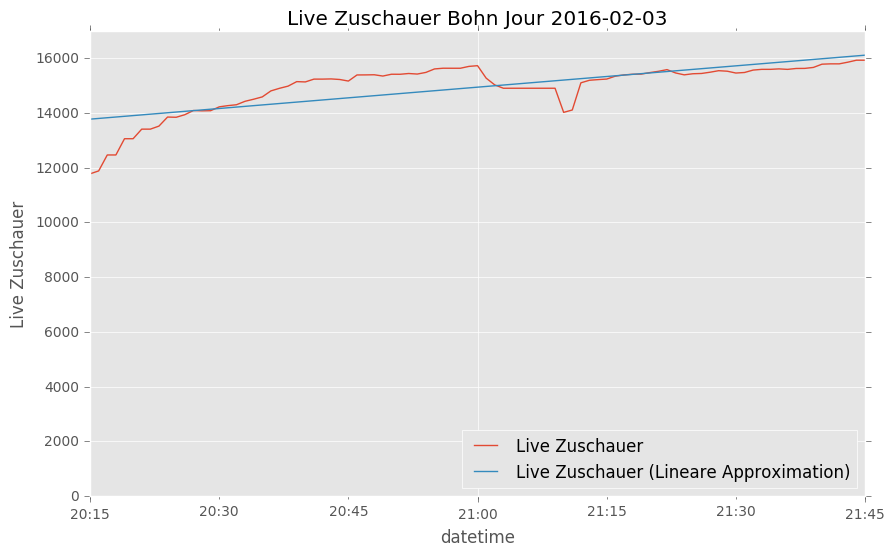

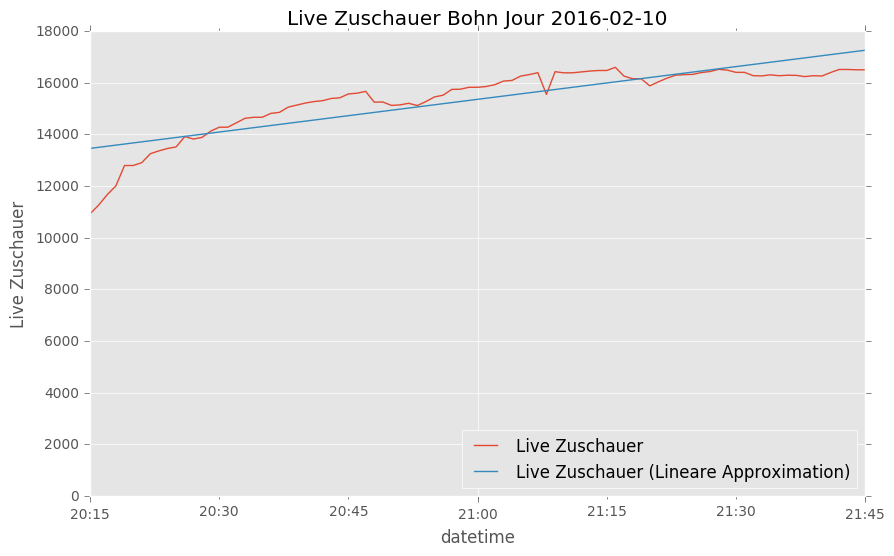

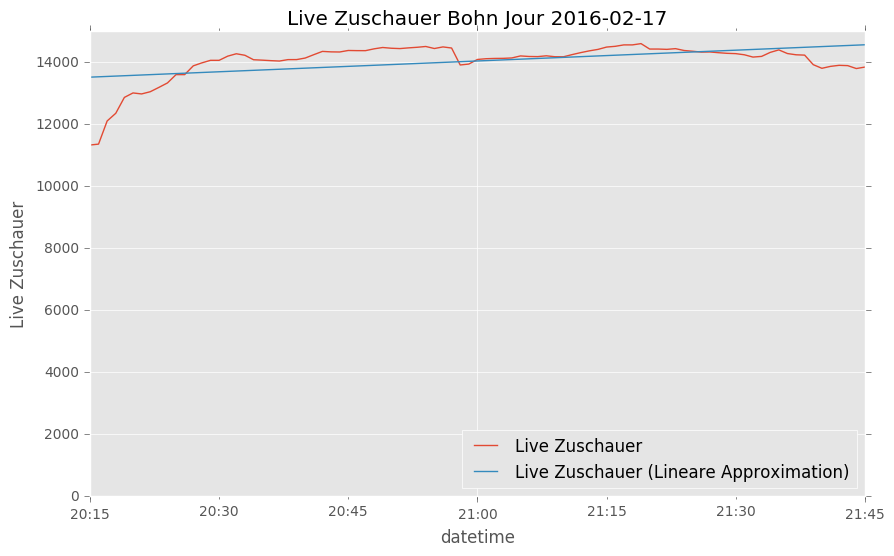

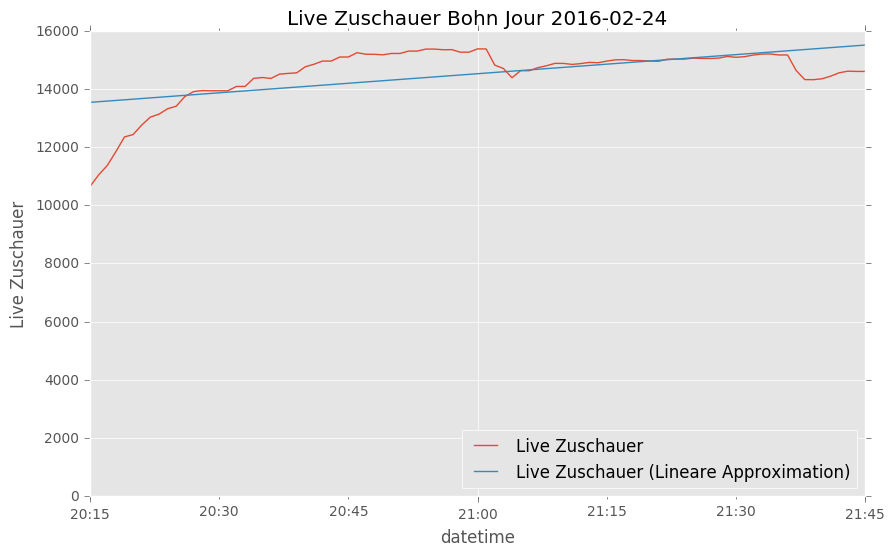

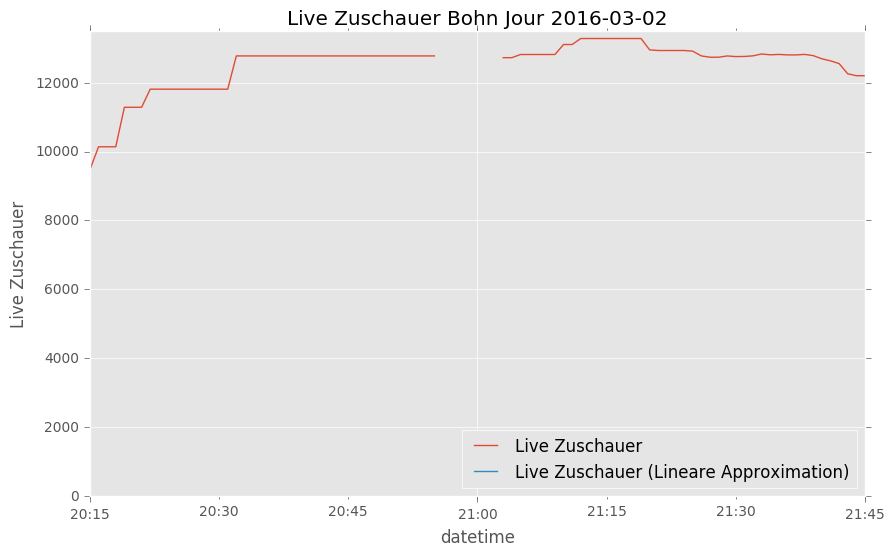

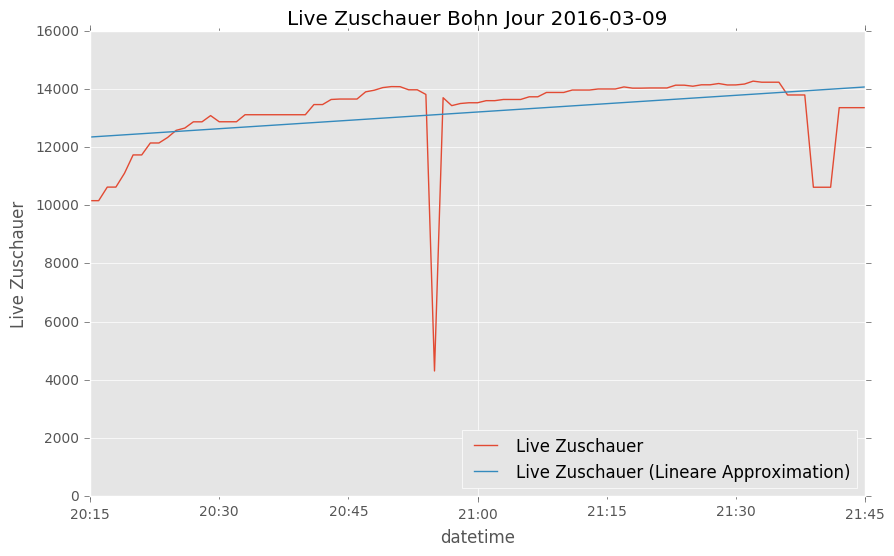

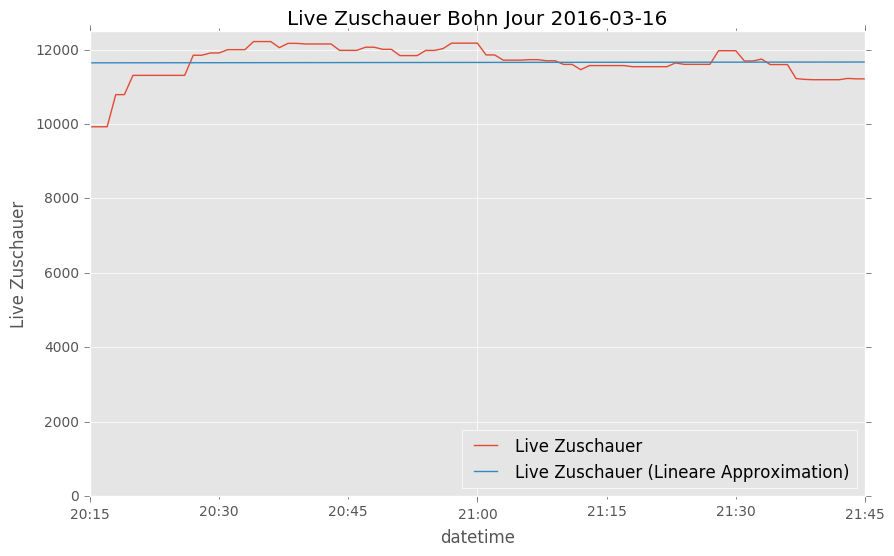

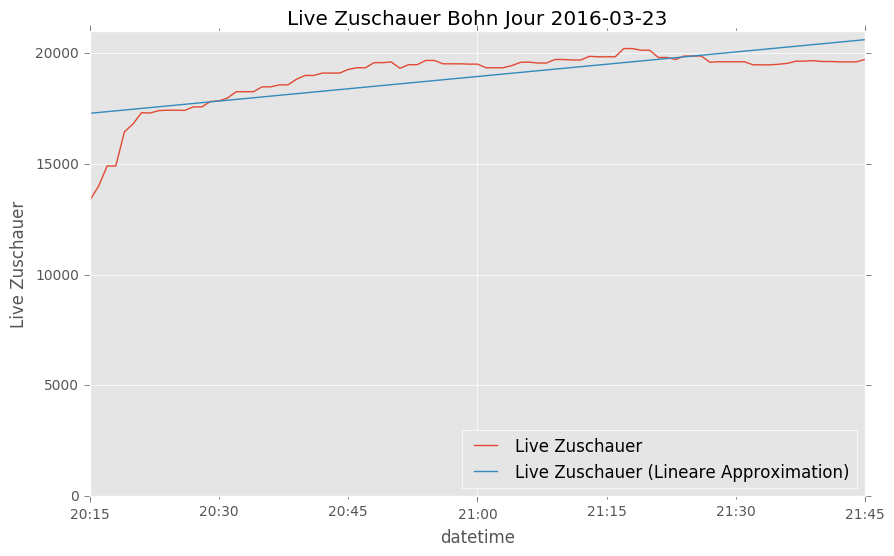

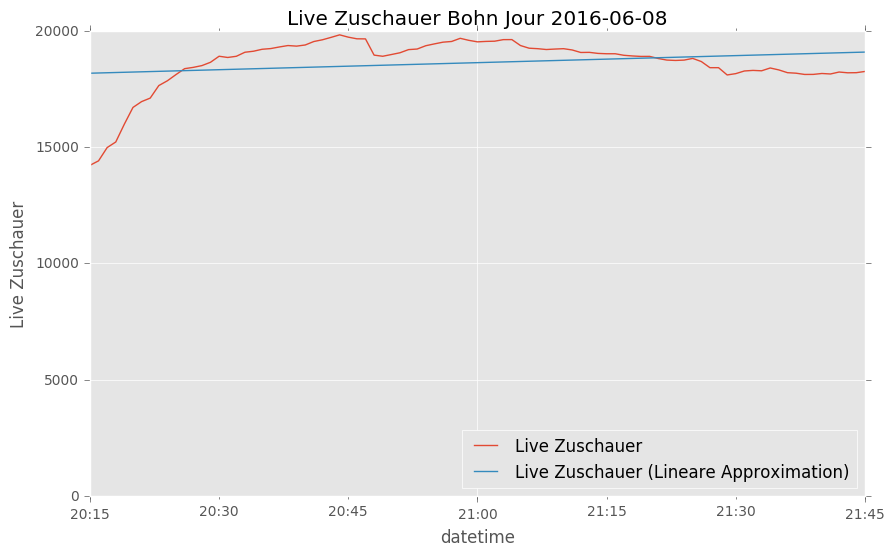

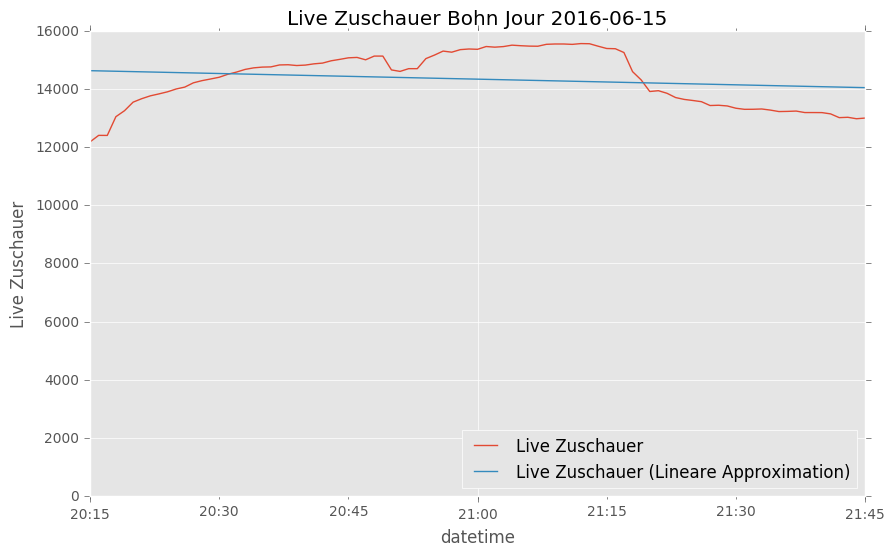

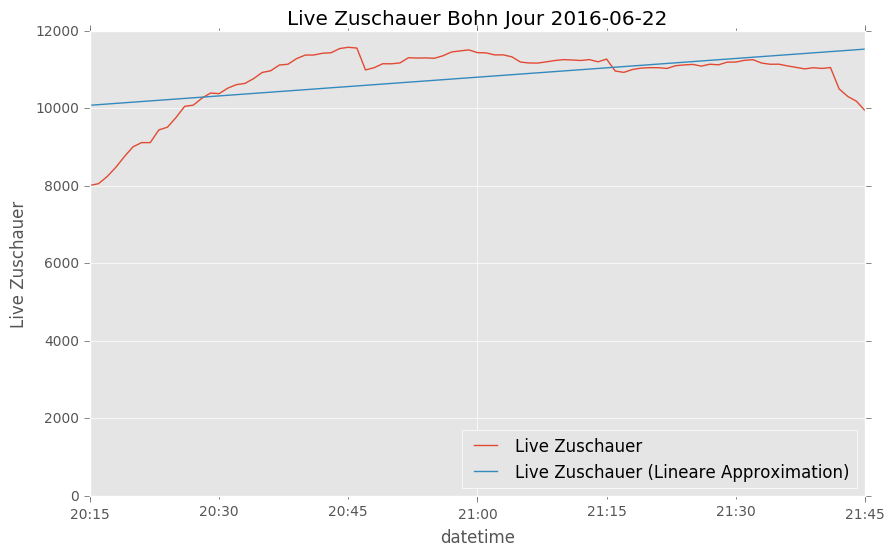

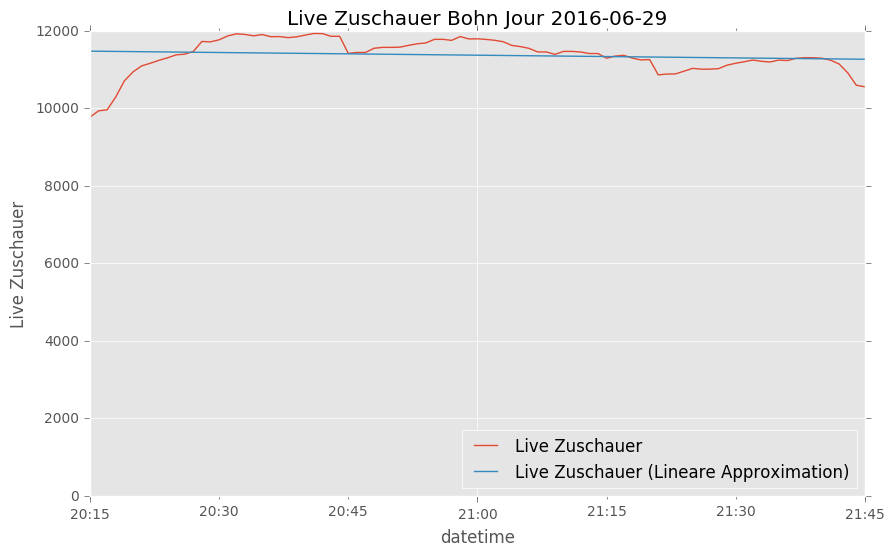

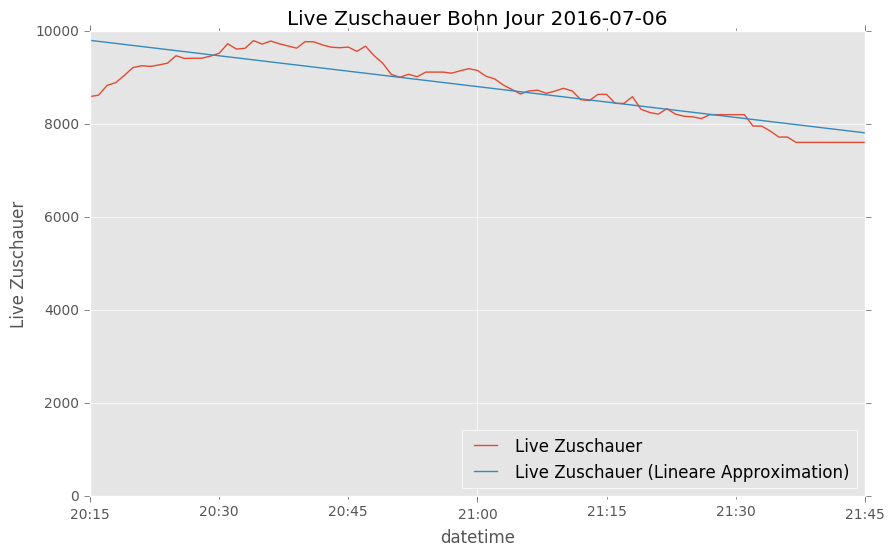

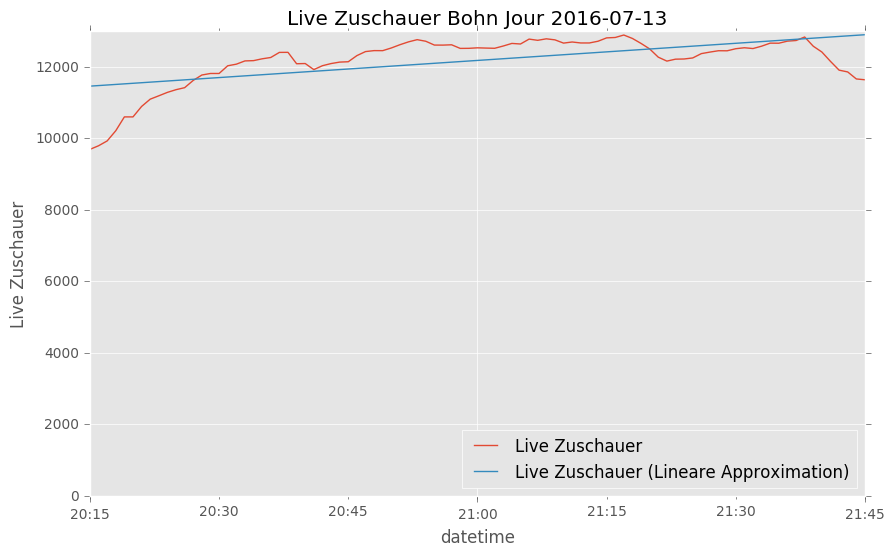

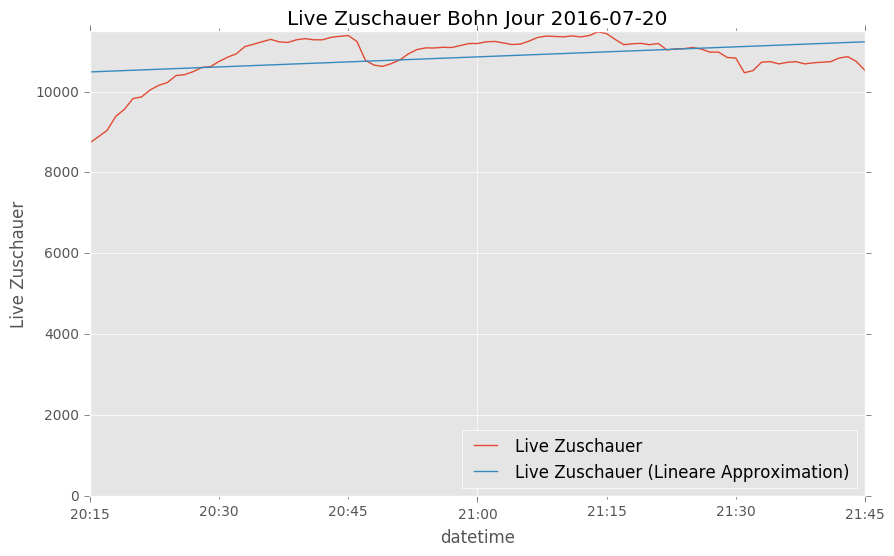

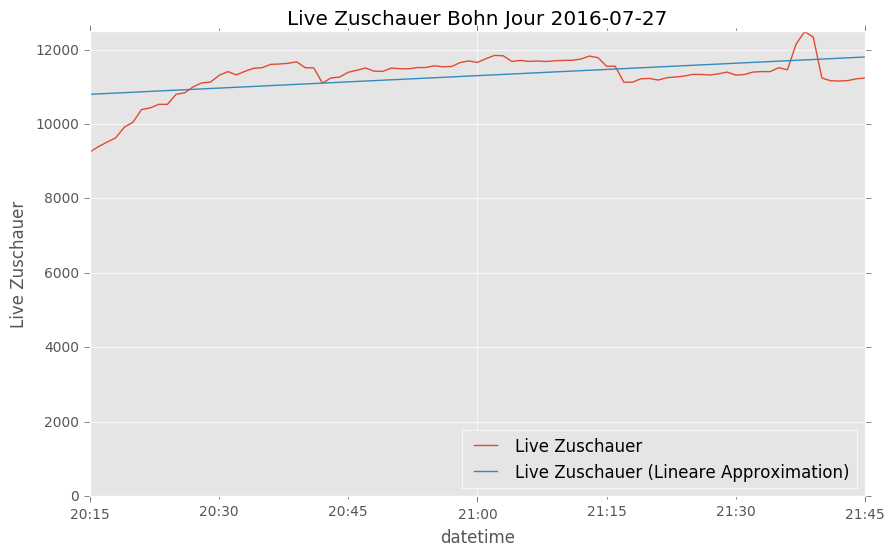

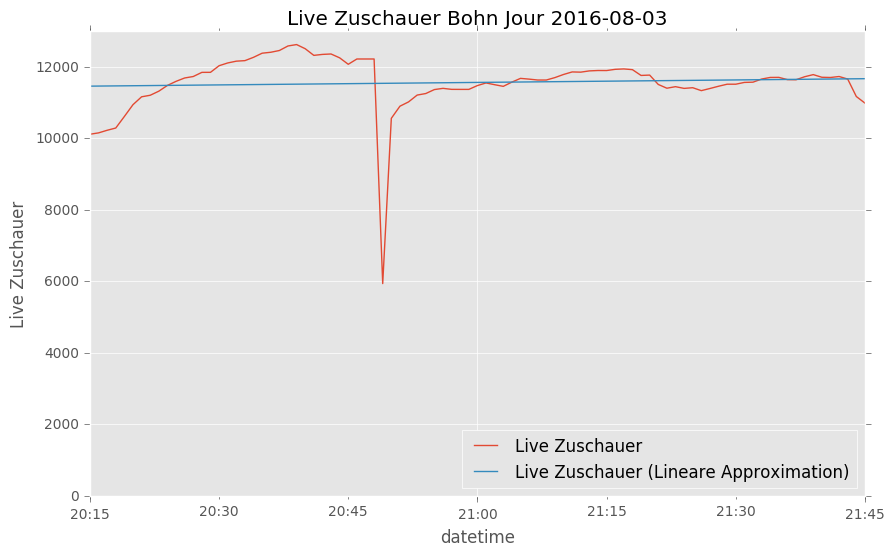

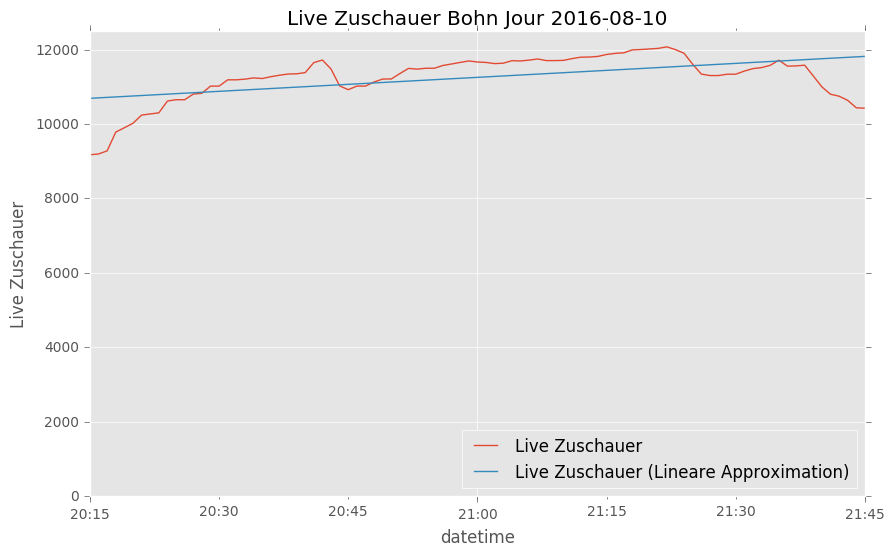

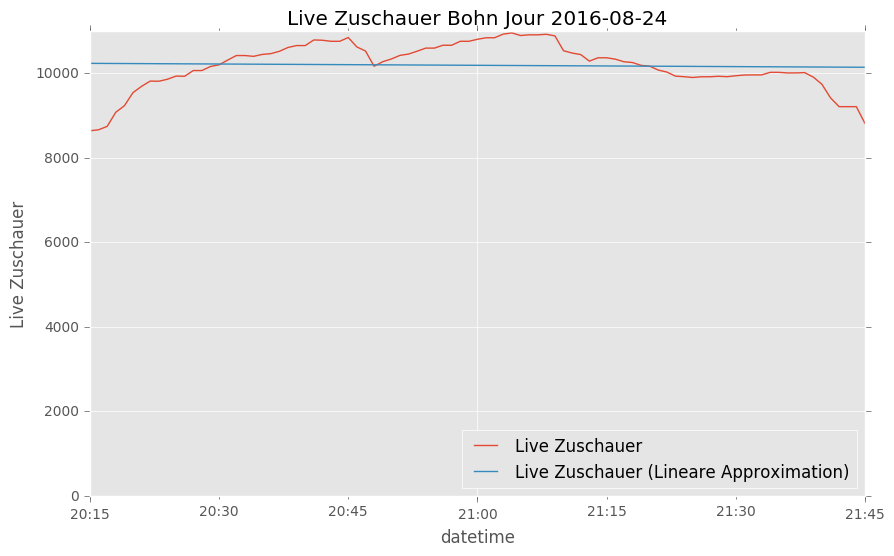

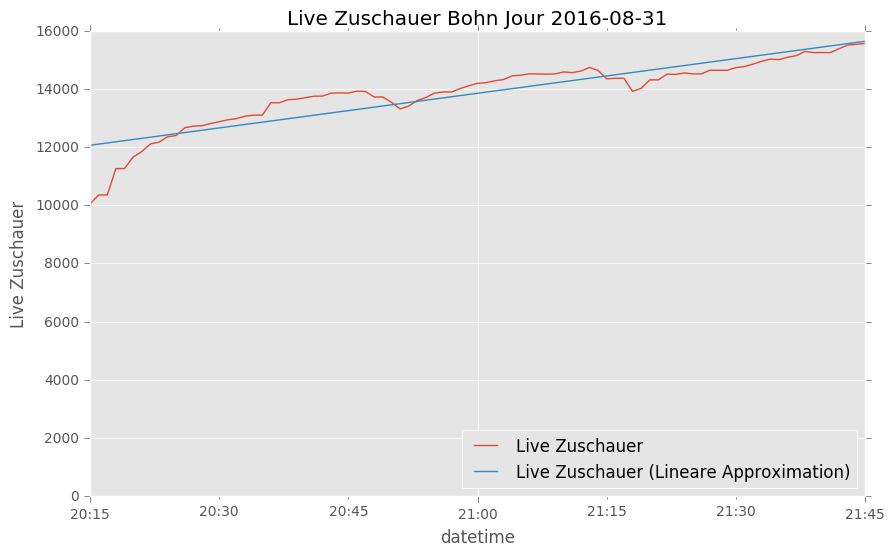

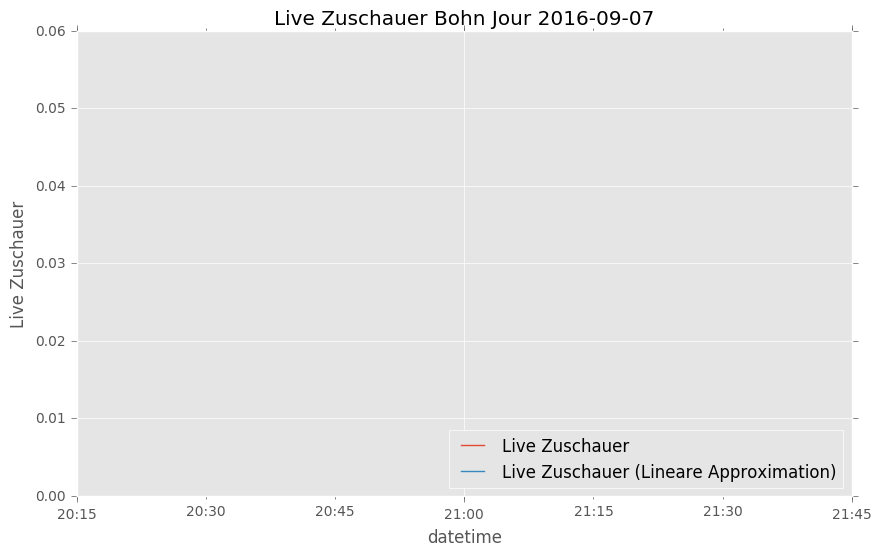

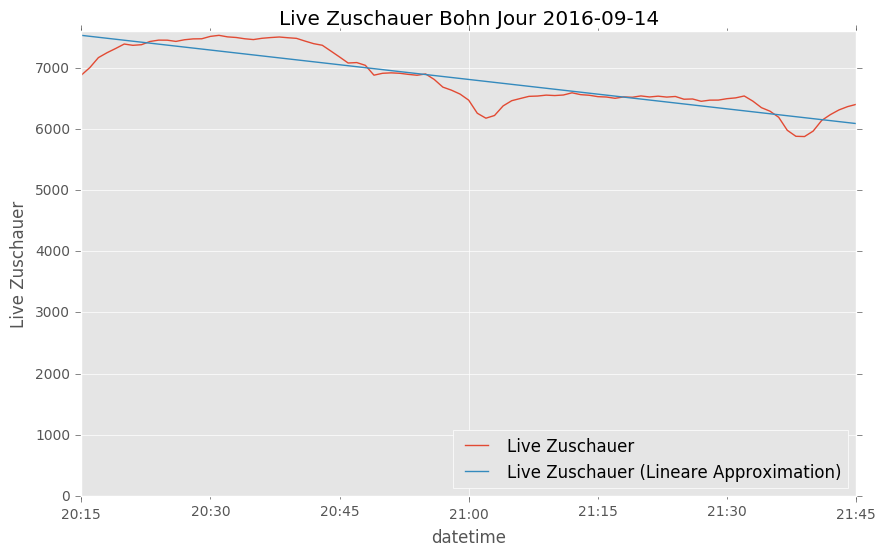

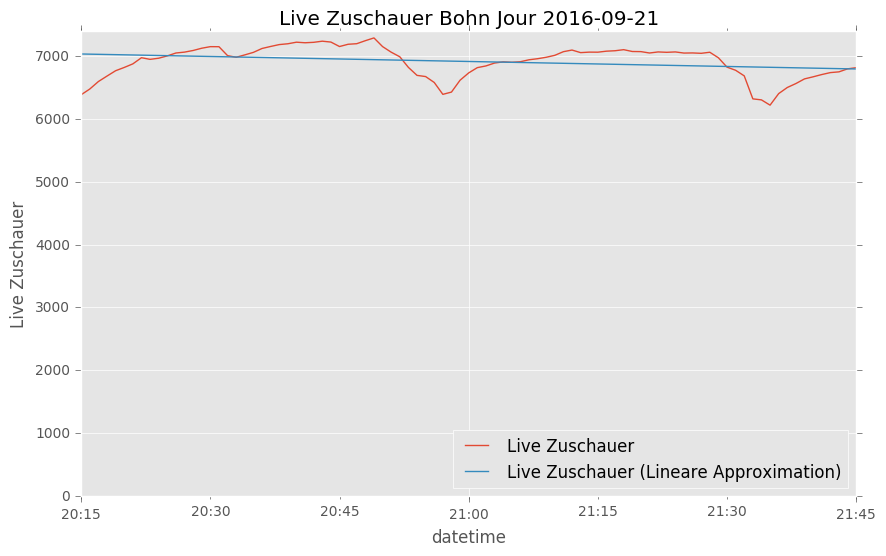

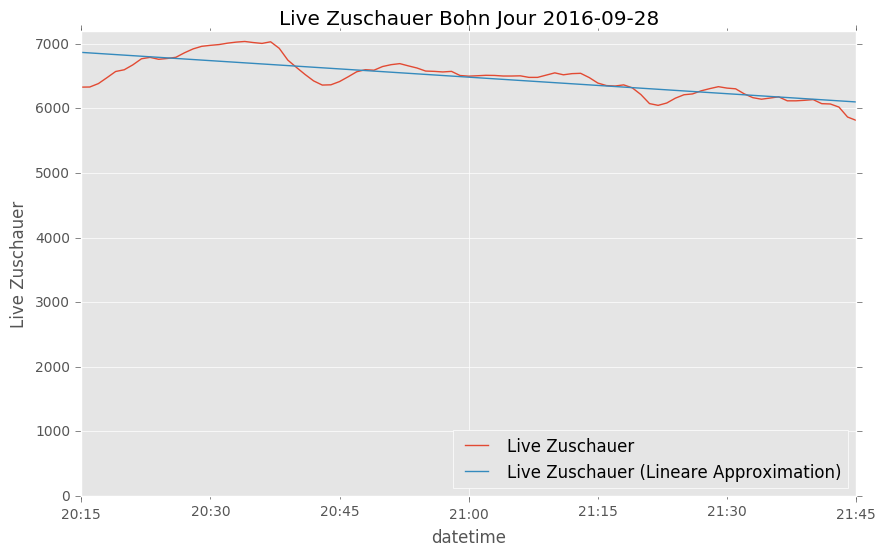

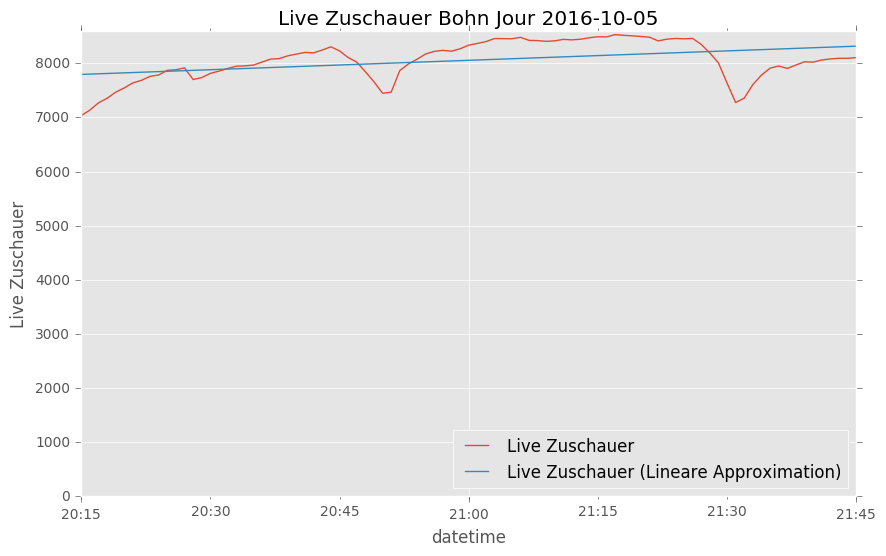

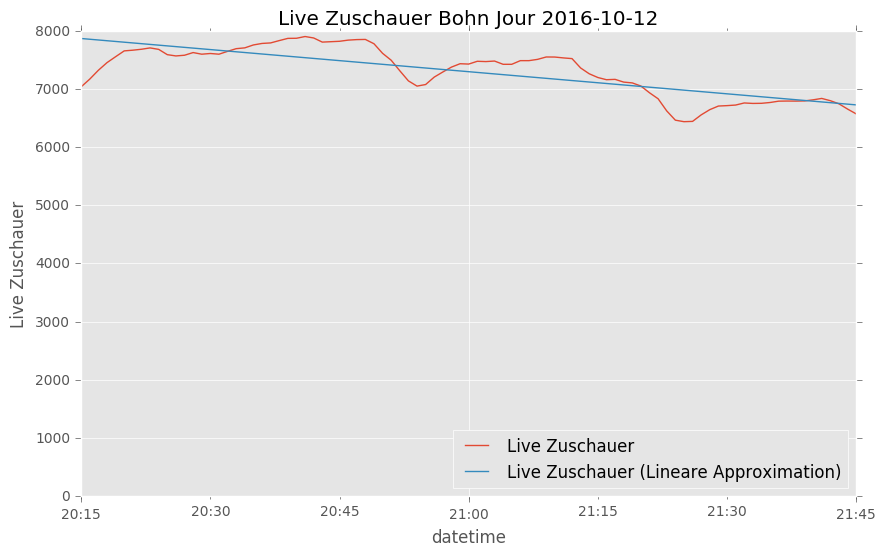

In [7]:
data = pd.DataFrame(columns=['live_views_mean', 
                             'live_views_slope',
                             'chat_messages', 
                             'chat_participants', 
                             'video_views_total',
                             'video_views_mean',
                             'video_views_drop',
                             'video_ratings_total',
                             'video_ratings_mean',
                             'video_ratings_like_total',
                             'video_ratings_like_mean',
                             'video_ratings_like_first',
                             'video_ratings_dislike_total',
                             'video_ratings_dislike_mean',
                             'video_ratings_dislike_first',
                             'video_ratings_ratio_total',
                             'video_ratings_ratio_mean',
                             'video_ratings_ratio_first',
                             'video_comments_total',
                             'video_comments_mean',
                             'video_comments_first'])

colors = []
for aired, videosGroup in videosGrouped:
    aired = datetime.datetime.strptime(aired, "%d.%m.%Y").date()

    if aired < bohnJour2Date:
        colors.append(bohnJour1Color)
    elif aired < youtubeAraDate:
        colors.append(bohnJour2TwitchColor)
    else:
        colors.append(bohnJour2YoutubeColor)

    videosGroup = videosGroup.sort_values('part')
    
    print(videosGroup)

    start = datetime.datetime.combine(aired, datetime.time(20, 15, 0))
    end = datetime.datetime.combine(aired, datetime.time(21, 45, 0))

    #filter live data by date
    liveFiltered = live.loc[start : end]

    #calculate linear regression
    x = np.array(liveFiltered.index.strftime('%s').tolist()).astype(int)
    y = np.array(liveFiltered['viewers'].tolist())
    slope, intercept, r_value, p_value, std_err = linregress(x,y)

    y = intercept + slope * x
    reg = pd.DataFrame(y, index=x, columns=['regression'])

    liveFiltered['viewers_regression'] = reg['regression'].tolist()

    #calculate live mean
    liveViewsMean = liveFiltered['viewers'].mean()

    #slope
    liveViewsSlope = slope

    #filter chat data by date
    chatFiltered = chat.loc[start : end]

    #count chat messages
    chatMessages = len(chatFiltered)

    #count unique users
    chatParticipants = len(chatFiltered['username'].unique())

    #views
    videoViewsTotal = videosGroup['viewCount'].sum()
    videoViewsMean = videosGroup['viewCount'].mean()
    firstVideo = videosGroup['viewCount'][0]
    secondVideo = videosGroup['viewCount'][1]
    videoViewsDrop = 100 * (firstVideo - secondVideo) / float(firstVideo)

    #ratings
    videoRatingsTotal = videosGroup['ratings_total'].sum()
    videoRatingsMean = videosGroup['ratings_total'].mean()

    #likes
    videoRatingsLikeTotal = videosGroup['likeCount'].sum()
    videoRatingsLikeMean = videosGroup['likeCount'].mean()
    videoRatingsLikeFirst = videosGroup['likeCount'][0]

    #dislikes
    videoRatingsDislikeTotal = videosGroup['dislikeCount'].sum()
    videoRatingsDislikeMean = videosGroup['dislikeCount'].mean()
    videoRatingsDislikeFirst = videosGroup['dislikeCount'][0]

    #ratio
    videoRatingsRatioTotal = 100 * videoRatingsLikeTotal / float(videoRatingsTotal)
    videoRatingsRatioMean = videosGroup['ratings_ratio'].mean()
    videoRatingsRatioFirst = videosGroup['ratings_ratio'][0]

    #comments
    videoCommentsTotal = videosGroup['commentCount'].sum()
    videoCommentsMean = videosGroup['commentCount'].mean()
    videoCommentsFirst = videosGroup['commentCount'][0]

    data.loc[aired] = [liveViewsMean, 
                       liveViewsSlope, 
                       chatMessages, 
                       chatParticipants, 
                       videoViewsTotal,
                       videoViewsMean,
                       videoViewsDrop,
                       videoRatingsTotal,
                       videoRatingsMean,
                       videoRatingsLikeTotal,
                       videoRatingsLikeMean,
                       videoRatingsLikeFirst,
                       videoRatingsDislikeTotal,
                       videoRatingsDislikeMean,
                       videoRatingsDislikeFirst,
                       videoRatingsRatioTotal,
                       videoRatingsRatioMean,
                       videoRatingsRatioFirst,
                       videoCommentsTotal,
                       videoCommentsMean,
                       videoCommentsFirst]

    plot = liveFiltered[['viewers', 'viewers_regression']].plot(kind='line', figsize=(10, 6), legend=False, title='Live Zuschauer Bohn Jour %s' % aired)
    plot.set_ylabel('Live Zuschauer')

    legend = plot.legend(loc=4)
    legend.get_texts()[0].set_text('Live Zuschauer')
    legend.get_texts()[1].set_text('Live Zuschauer (Lineare Approximation)')

    plt.ylim(ymin=0)
    plt.show()

In [8]:
dataSeason1 = data.loc[:bohnJour2Date]
dataSeason2Twitch = data.loc[bohnJour2Date:youtubeAraDate]
dataSeason2Youtube = data.loc[youtubeAraDate:]

data

,live_views_mean,live_views_slope,chat_messages,chat_participants,video_views_total,video_views_mean,video_views_drop,video_ratings_total,video_ratings_mean,video_ratings_like_total,...,video_ratings_like_first,video_ratings_dislike_total,video_ratings_dislike_mean,video_ratings_dislike_first,video_ratings_ratio_total,video_ratings_ratio_mean,video_ratings_ratio_first,video_comments_total,video_comments_mean,video_comments_first
2015-08-05,11547.549451,-1.118148,3265.0,1008.0,110392.0,36797.333333,32.788793,3389.0,1129.666667,3342.0,...,1480.0,47.0,15.666667,21.0,98.613160,98.622900,98.600933,315.0,105.000000,123.0
2015-08-12,13877.197802,0.408935,9987.0,1819.0,94565.0,31521.666667,15.323947,2591.0,863.666667,2527.0,...,1008.0,64.0,21.333333,24.0,97.529911,97.504121,97.674419,242.0,80.666667,112.0
2015-08-26,13548.615385,0.301143,9327.0,1688.0,76364.0,25454.666667,35.445390,2443.0,814.333333,2407.0,...,991.0,36.0,12.000000,17.0,98.526402,98.551928,98.313492,296.0,98.666667,160.0
2015-09-02,13680.406593,0.478941,10612.0,1832.0,88643.0,29547.666667,8.216968,2373.0,791.000000,2338.0,...,865.0,35.0,11.666667,14.0,98.525074,98.526921,98.407281,292.0,97.333333,125.0
2015-09-09,13872.197802,0.602278,9042.0,1788.0,95504.0,31834.666667,6.573257,3007.0,1002.333333,2993.0,...,1021.0,14.0,4.666667,5.0,99.534420,99.539400,99.512671,257.0,85.666667,95.0
2015-09-16,12712.065934,0.393110,12505.0,1911.0,101100.0,33700.000000,10.794031,3194.0,1064.666667,3129.0,...,1025.0,65.0,21.666667,30.0,97.964934,97.914575,97.156398,449.0,149.666667,148.0
2015-09-23,12809.472527,0.075239,10435.0,1739.0,80141.0,26713.666667,29.174179,2510.0,836.666667,2477.0,...,1121.0,33.0,11.000000,8.0,98.685259,98.559563,99.291408,260.0,86.666667,107.0
2015-09-30,12151.879121,0.120818,13619.0,2476.0,70034.0,23344.666667,12.230983,1959.0,653.000000,1892.0,...,745.0,67.0,22.333333,33.0,96.579888,96.667403,95.758355,326.0,108.666667,228.0
2015-10-07,14035.890110,0.369195,13966.0,2408.0,80949.0,26983.000000,23.860756,2150.0,716.666667,2050.0,...,803.0,100.0,33.333333,12.0,95.348837,95.213815,98.527607,299.0,99.666667,95.0
2015-10-14,15071.582418,0.697082,16734.0,2457.0,81739.0,27246.333333,-29.635505,2366.0,788.666667,2336.0,...,718.0,30.0,10.000000,5.0,98.732037,98.828193,99.308437,287.0,95.666667,87.0


## Live Zuschauer

Die durchschnittlichen Zuschauer von Bohn Jour im Zeitraum von 20:15 Uhr bis 21:45 Uhr.

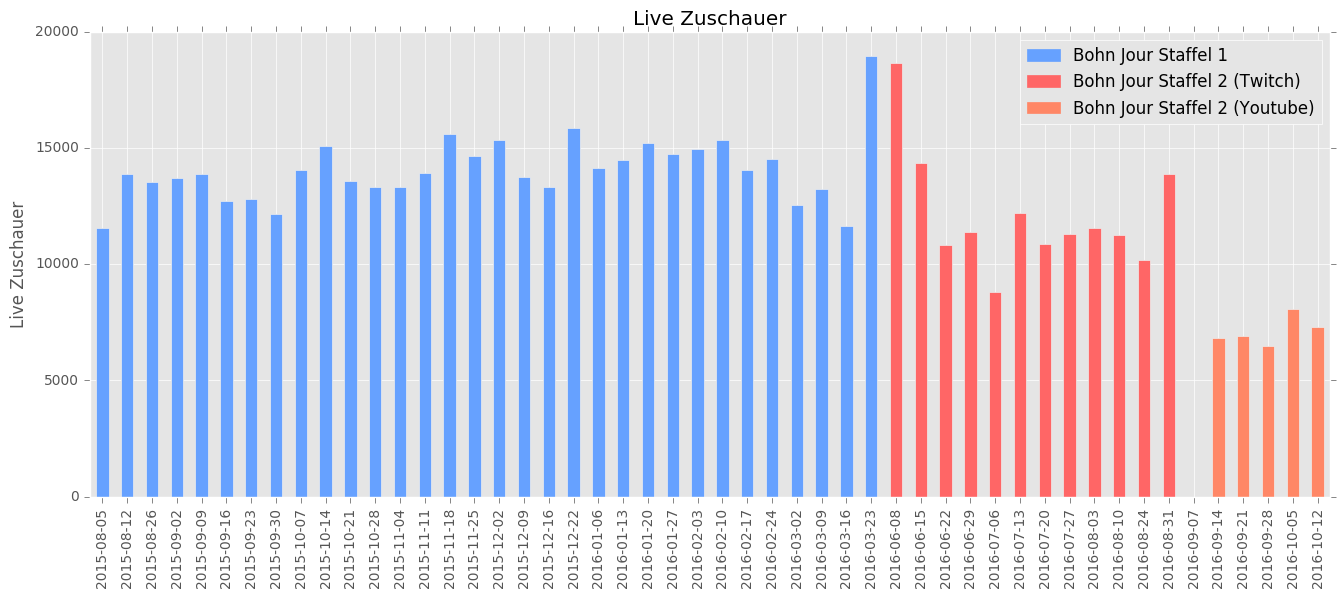

In [9]:
plot = data['live_views_mean'].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Live Zuschauer')
plot.set_ylabel('Live Zuschauer')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

In [10]:
subDataSeason1 = dataSeason1['live_views_mean'].to_frame('Bohn Jour Staffel 1')
subDataSeason2Twitch = dataSeason2Twitch['live_views_mean'].to_frame('Bohn Jour Staffel 2 (Twitch)')
subDataSeason2Youtube = dataSeason2Youtube['live_views_mean'].to_frame('Bohn Jour Staffel 2 (Youtube)')

joinedData = subDataSeason1.join(subDataSeason2Twitch, how='outer').join(subDataSeason2Youtube, how='outer')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,5.000000
mean,14049.590602,12095.740842,7112.347253
std,1411.100375,2536.104068,602.898921
min,11547.549451,8803.230769,6484.340659
25%,13307.755495,10845.717033,6807.340659
50%,13889.478022,11336.049451,6914.120879
75%,14776.409341,12595.489011,7298.901099
max,18942.802198,18636.076923,8057.032967


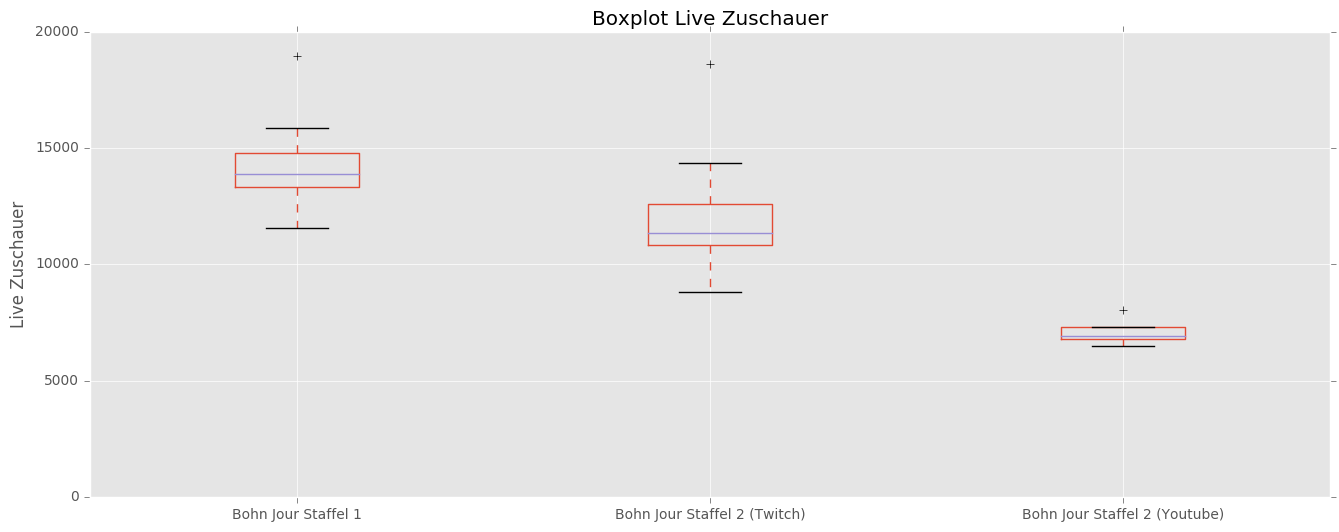

In [11]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Live Zuschauer')
plot.set_ylabel('Live Zuschauer')

plt.ylim(ymin=0)

plot

## Live Zuschauer Steigung

Die Steigung bezieht sich auf die lineare Approximation der Live Zuschauer, vom Anfang bis zum Ende von Bohn Jour. Diese Gerade ist auch oben in den Diagrammen zum Verlauf der Live Zuschauer eingezeichnet. Ein negativer Wert stellt einen Zuschauerschwund dar, ein positiver Wert einen Zuschauerwachstum.

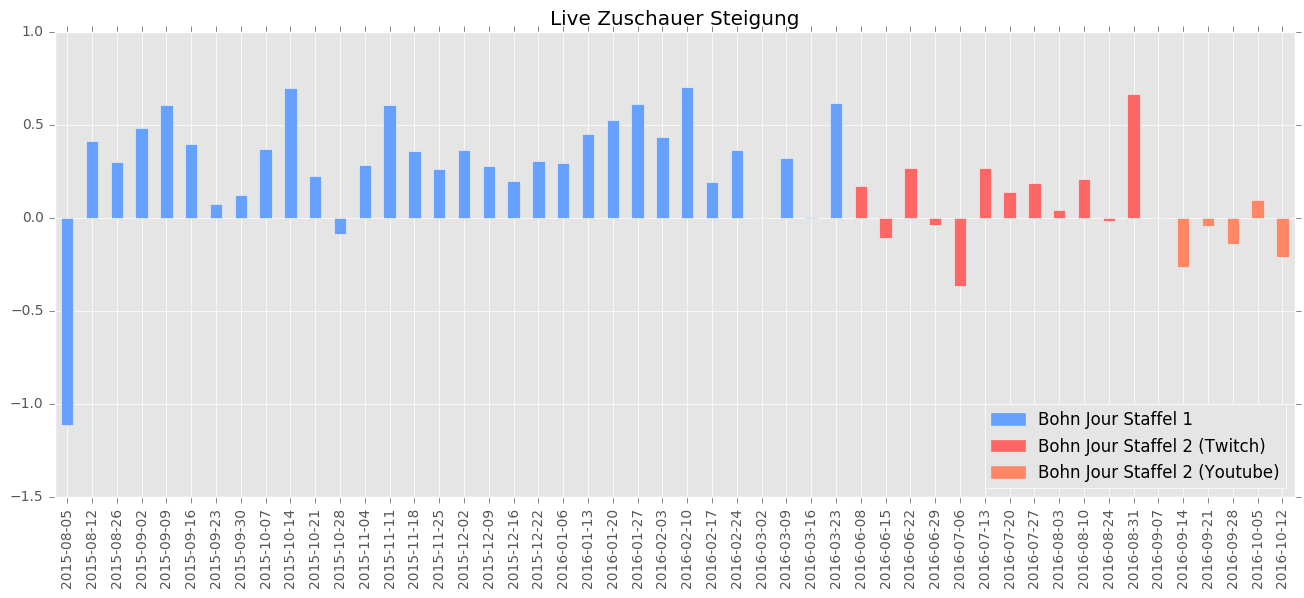

In [12]:
plot = data['live_views_slope'].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Live Zuschauer Steigung')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

In [13]:
subDataSeason1 = dataSeason1['live_views_slope'].to_frame('Bohn Jour Staffel 1')
subDataSeason2Twitch = dataSeason2Twitch['live_views_slope'].to_frame('Bohn Jour Staffel 2 (Twitch)')
subDataSeason2Youtube = dataSeason2Youtube['live_views_slope'].to_frame('Bohn Jour Staffel 2 (Youtube)')

joinedData = subDataSeason1.join(subDataSeason2Twitch, how='outer').join(subDataSeason2Youtube, how='outer')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,31.000000,12.000000,5.000000
mean,0.310251,0.117016,-0.113622
std,0.327523,0.251137,0.144059
min,-1.118148,-0.368408,-0.267080
25%,0.242866,-0.022490,-0.211461
50%,0.355038,0.153110,-0.142159
75%,0.463962,0.223105,-0.044142
max,0.703575,0.662663,0.096732


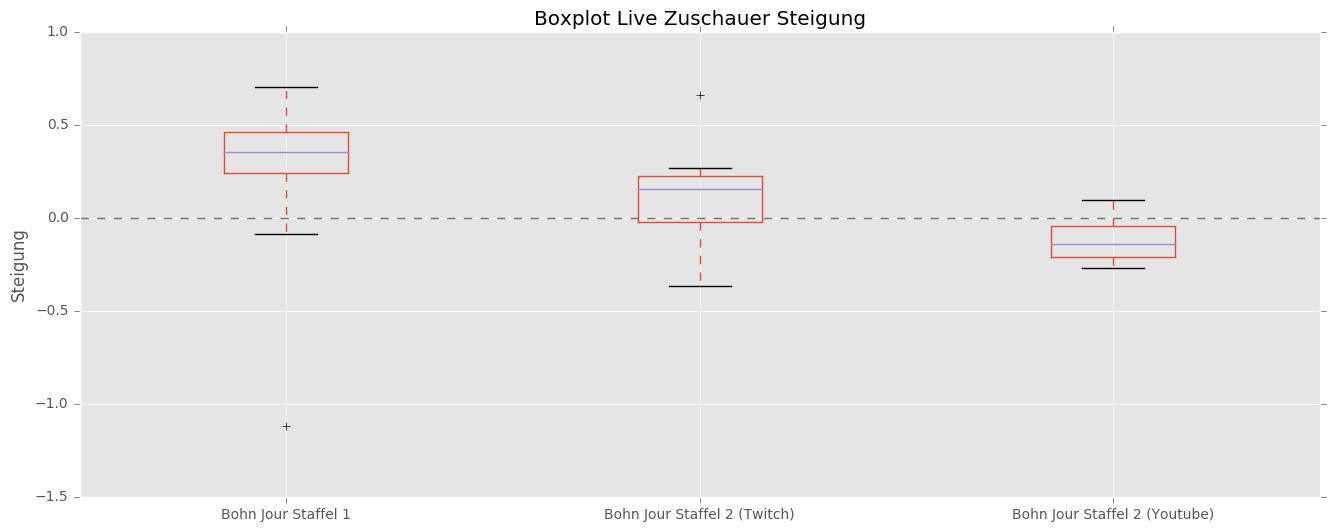

In [14]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Live Zuschauer Steigung')
plot.set_ylabel('Steigung')

plt.axhline(y=0, color='#727272',ls='dashed')

plot

## Chat Nachrichten & Teilnehmer

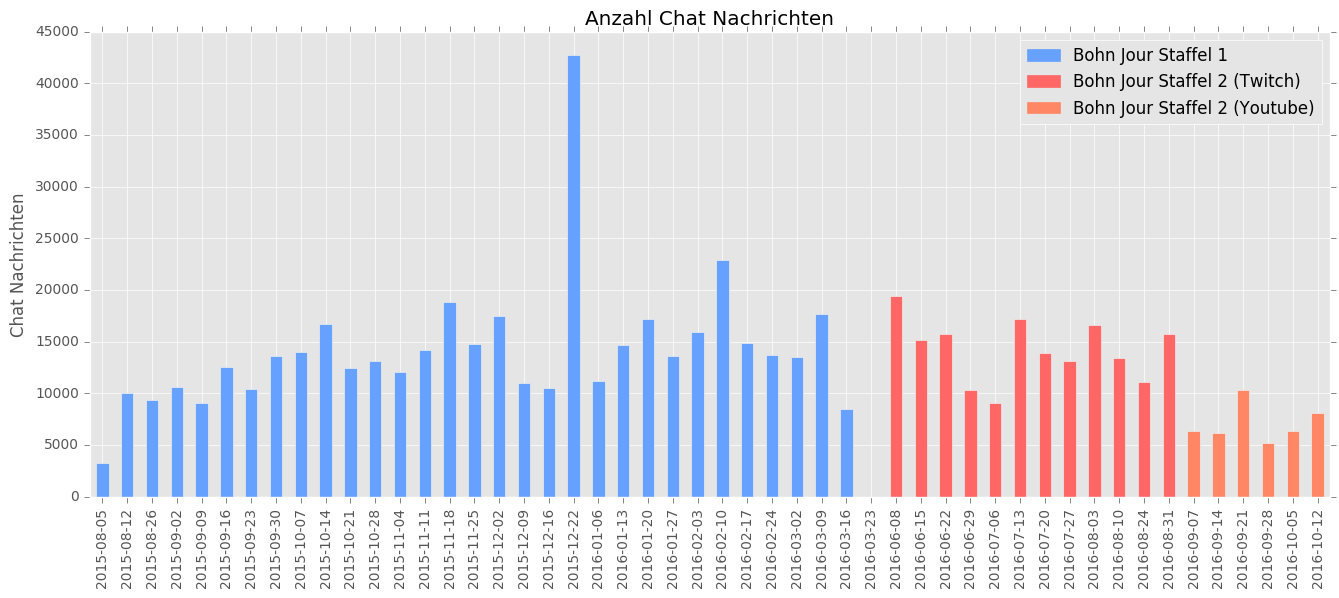

In [15]:
plot = data[['chat_messages']].plot(kind='bar', figsize=(16, 6), legend=False, color=colors, title='Anzahl Chat Nachrichten')
plot.set_ylabel('Chat Nachrichten')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

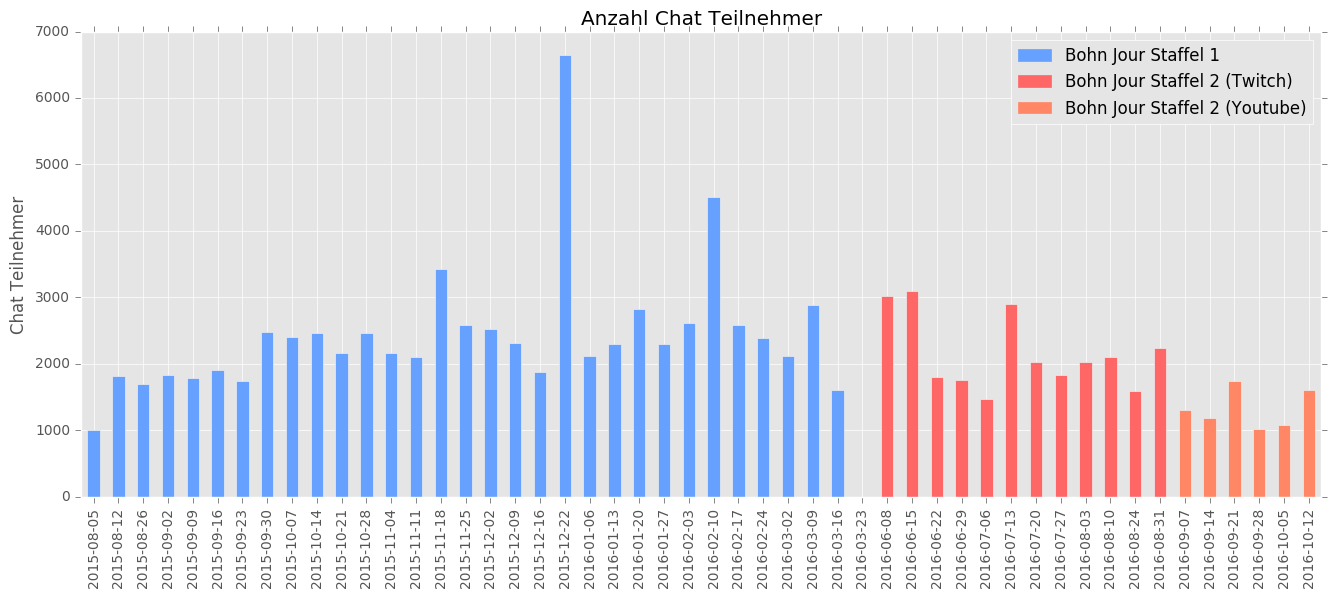

In [16]:
plot = data[['chat_participants']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Chat Teilnehmer')
plot.set_ylabel('Chat Teilnehmer')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

## Video Views

Alle nachfolgenden Daten beziehen sich auf die Video Views auf Youtube. Bohn Jour besteht i. d. R. aus 3 Teilen. Im folgenden wird unterschieden zwischen:

- __Gesamte Views__: Die Summe der Views aller Video Teile
- __Durchschnittliche Views__: Das arithmetische Mittel der Views aus allen Video Teilen

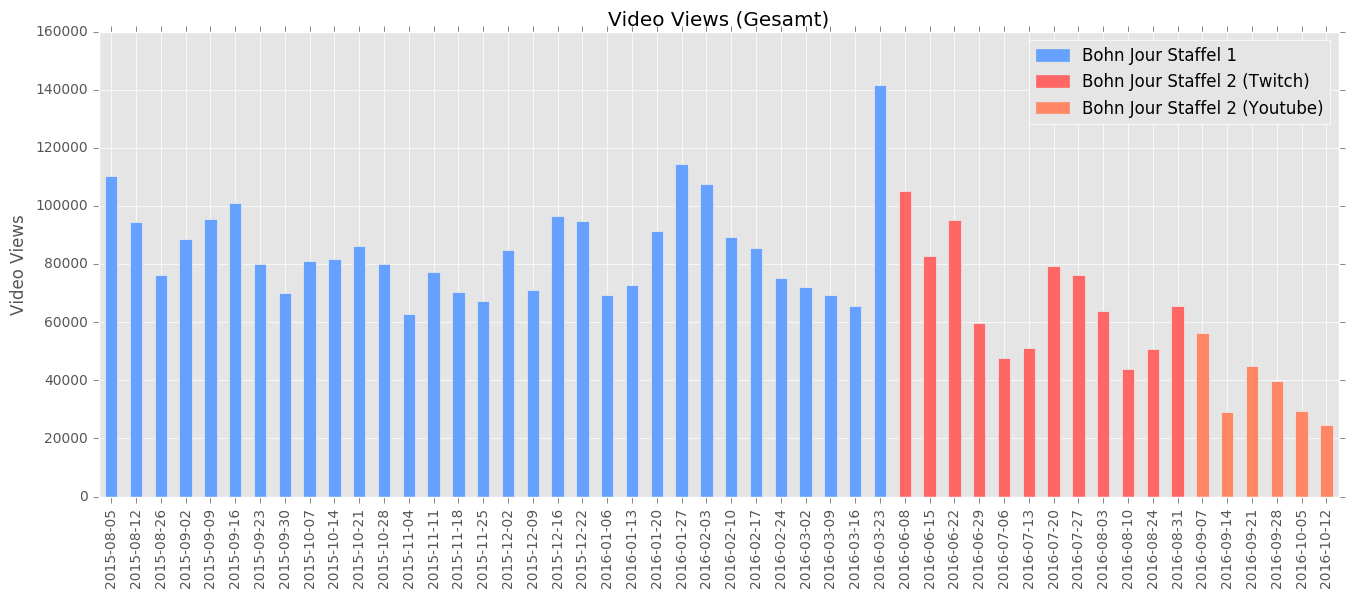

In [17]:
plot = data[['video_views_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Video Views (Gesamt)')
plot.set_ylabel('Video Views')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

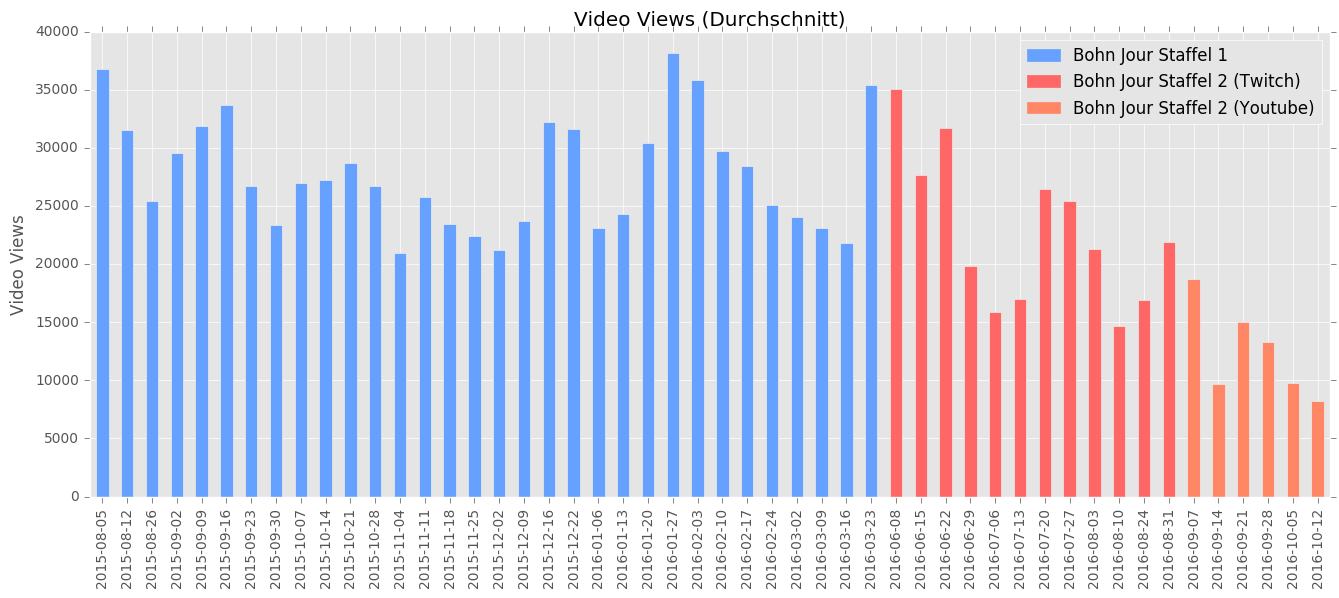

In [18]:
plot = data[['video_views_mean']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Video Views (Durchschnitt)')
plot.set_ylabel('Video Views')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

In [19]:
subDataSeason1 = dataSeason1['video_views_mean'].to_frame('Bohn Jour Staffel 1')
subDataSeason2Twitch = dataSeason2Twitch['video_views_mean'].to_frame('Bohn Jour Staffel 2 (Twitch)')
subDataSeason2Youtube = dataSeason2Youtube['video_views_mean'].to_frame('Bohn Jour Staffel 2 (Youtube)')

joinedData = subDataSeason1.join(subDataSeason2Twitch, how='outer').join(subDataSeason2Youtube, how='outer')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,6.000000
mean,27786.463542,22818.583333,12464.166667
std,4843.509062,6522.758082,3980.944448
min,20984.000000,14662.000000,8211.333333
25%,23606.083333,16978.166667,9740.000000
50%,26848.333333,21605.166667,11555.500000
75%,31546.083333,26780.250000,14580.250000
max,38111.000000,35048.333333,18739.333333


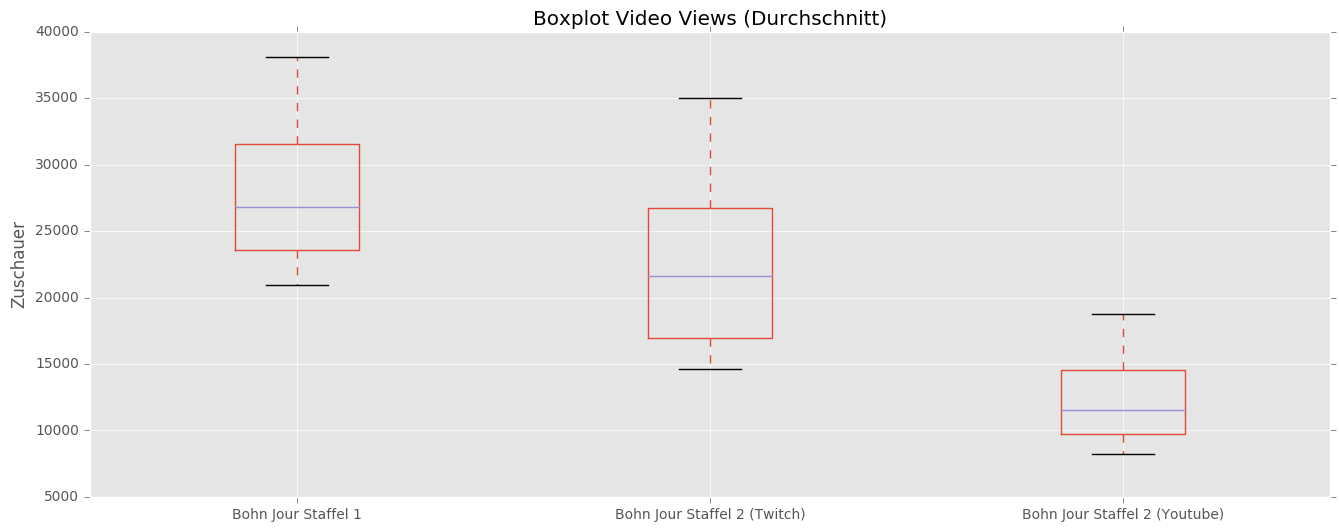

In [20]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Video Views (Durchschnitt)')
plot.set_ylabel('Zuschauer')

plot

## Video Views Änderung

Die Änderung der Differenz der Video Views vom ersten und zweiten Video Teil. Bei einem positiven Wert wurde der zweite Teil weniger angeschaut als der erste, bei einem negativem Wert entsprechend mehr.

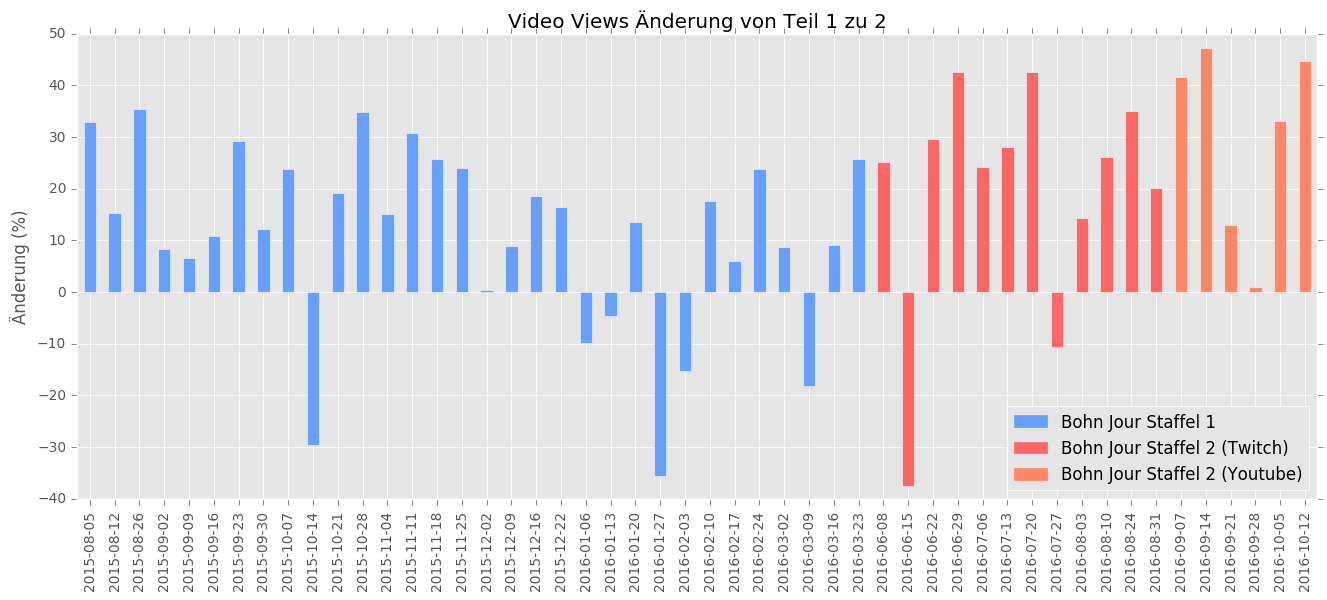

In [21]:
plot = data[['video_views_drop']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Video Views Änderung von Teil 1 zu 2')
plot.set_ylabel('Änderung (%)')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

In [22]:
subDataSeason1 = dataSeason1['video_views_drop'].to_frame('Bohn Jour Staffel 1')
subDataSeason2Twitch = dataSeason2Twitch['video_views_drop'].to_frame('Bohn Jour Staffel 2 (Twitch)')
subDataSeason2Youtube = dataSeason2Youtube['video_views_drop'].to_frame('Bohn Jour Staffel 2 (Youtube)')

joinedData = subDataSeason1.join(subDataSeason2Twitch, how='outer').join(subDataSeason2Youtube, how='outer')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,6.000000
mean,11.223684,19.944719,30.063277
std,17.747552,22.892821,18.938137
min,-35.717911,-37.525443,0.969889
25%,6.434476,18.600208,17.891587
50%,14.296901,25.624487,37.324468
75%,23.893205,30.939377,43.985229
max,35.445390,42.580432,47.141395


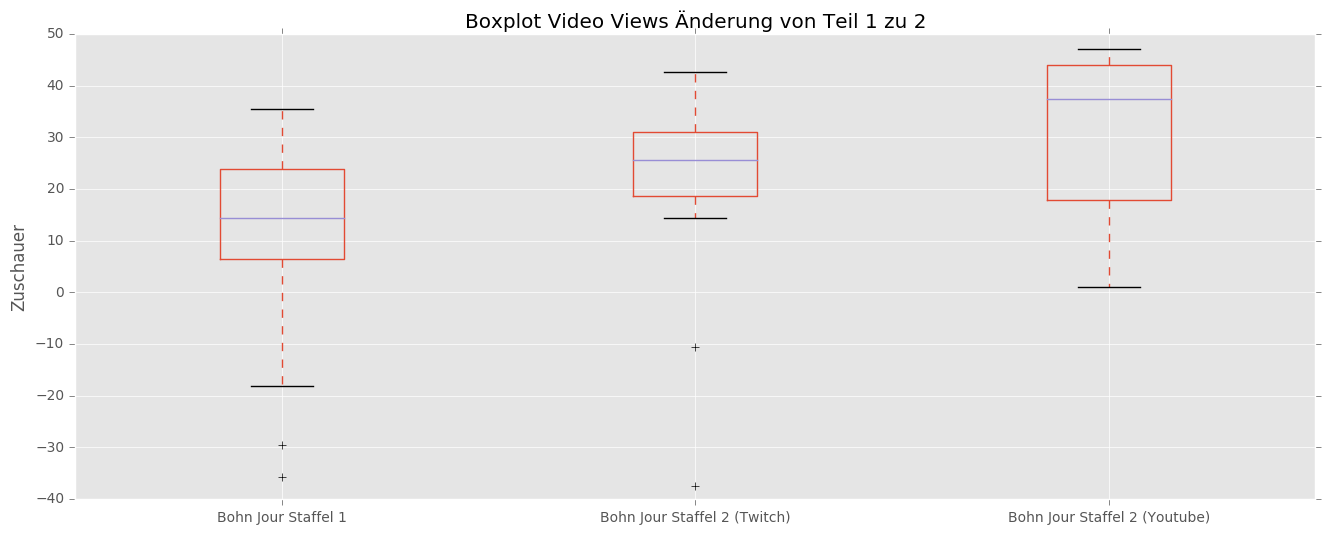

In [23]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Video Views Änderung von Teil 1 zu 2')
plot.set_ylabel('Zuschauer')

plot

## Video Bewertungen

- __Gesamte Bewertungen__: Die Summe der Bewertungen aller Video Teile
- __Durchschnittliche Bewertungen__: Das arithmetische Mittel der Bewertungen aus allen Video Teilen

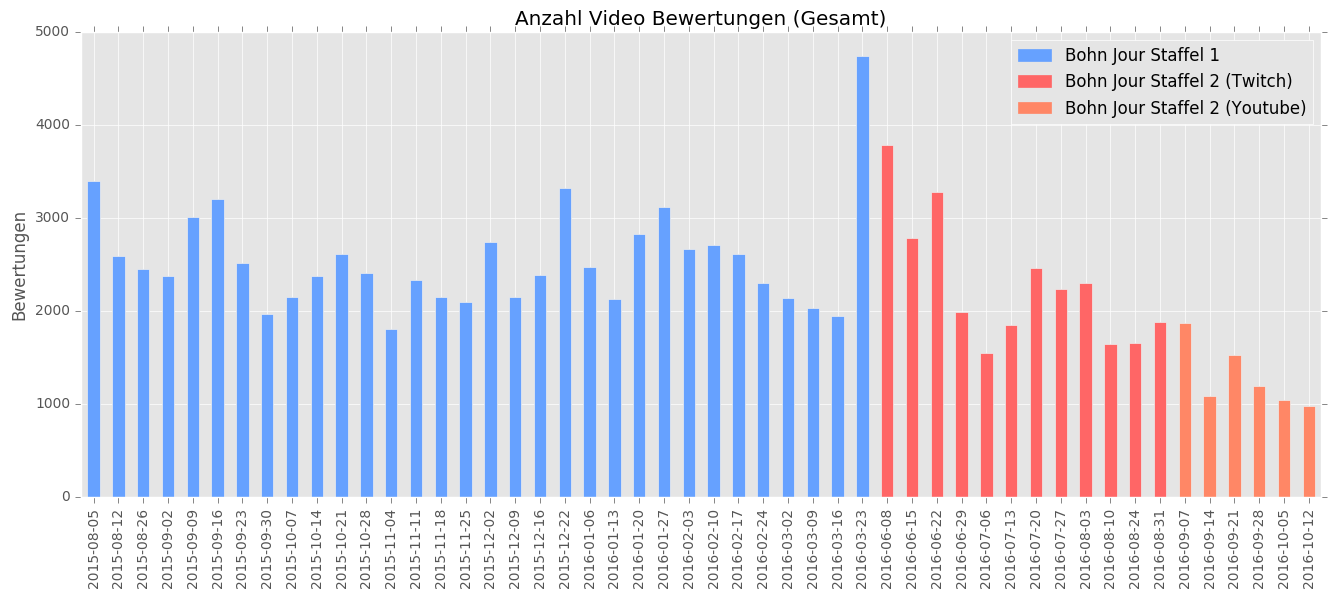

In [24]:
plot = data[['video_ratings_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Bewertungen (Gesamt)')
plot.set_ylabel('Bewertungen')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

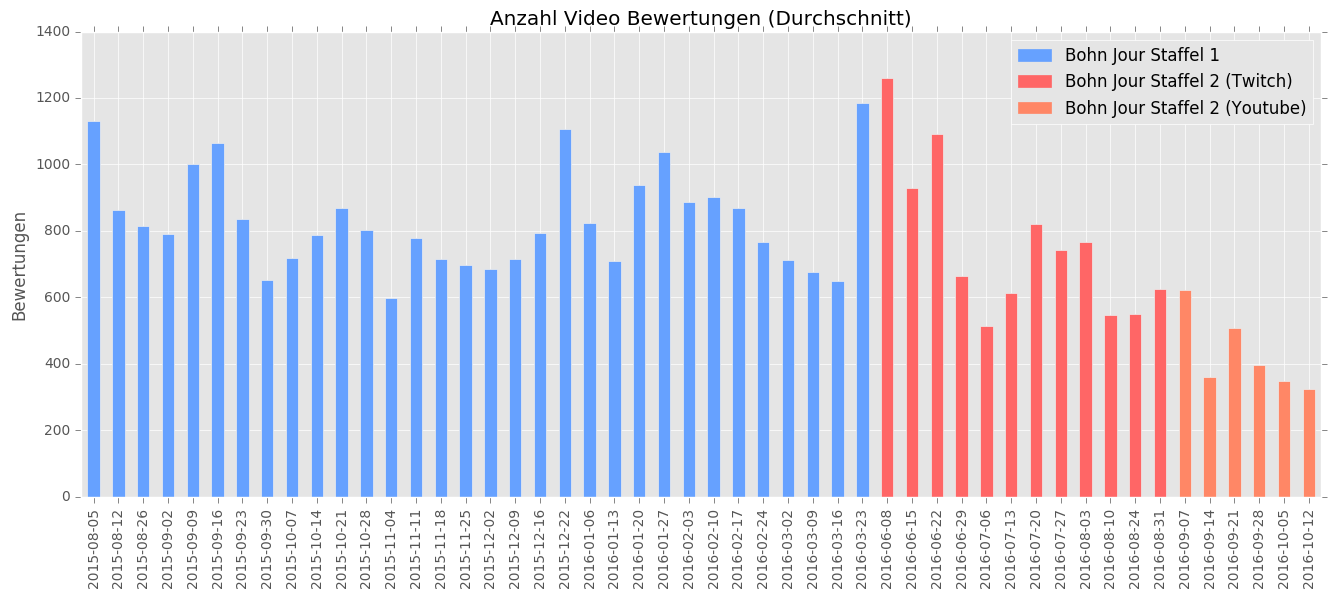

In [25]:
plot = data[['video_ratings_mean']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Bewertungen (Durchschnitt)')
plot.set_ylabel('Bewertungen')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

In [26]:
subDataSeason1 = dataSeason1['video_ratings_mean'].to_frame('Bohn Jour Staffel 1')
subDataSeason2Twitch = dataSeason2Twitch['video_ratings_mean'].to_frame('Bohn Jour Staffel 2 (Twitch)')
subDataSeason2Youtube = dataSeason2Youtube['video_ratings_mean'].to_frame('Bohn Jour Staffel 2 (Youtube)')

joinedData = subDataSeason1.join(subDataSeason2Twitch, how='outer').join(subDataSeason2Youtube, how='outer')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,6.000000
mean,830.059896,760.000000,425.777778
std,150.709229,231.790048,114.888674
min,599.000000,513.333333,324.666667
25%,712.916667,598.000000,350.666667
50%,796.833333,703.333333,377.666667
75%,890.500000,846.916667,478.916667
max,1183.750000,1260.666667,620.333333


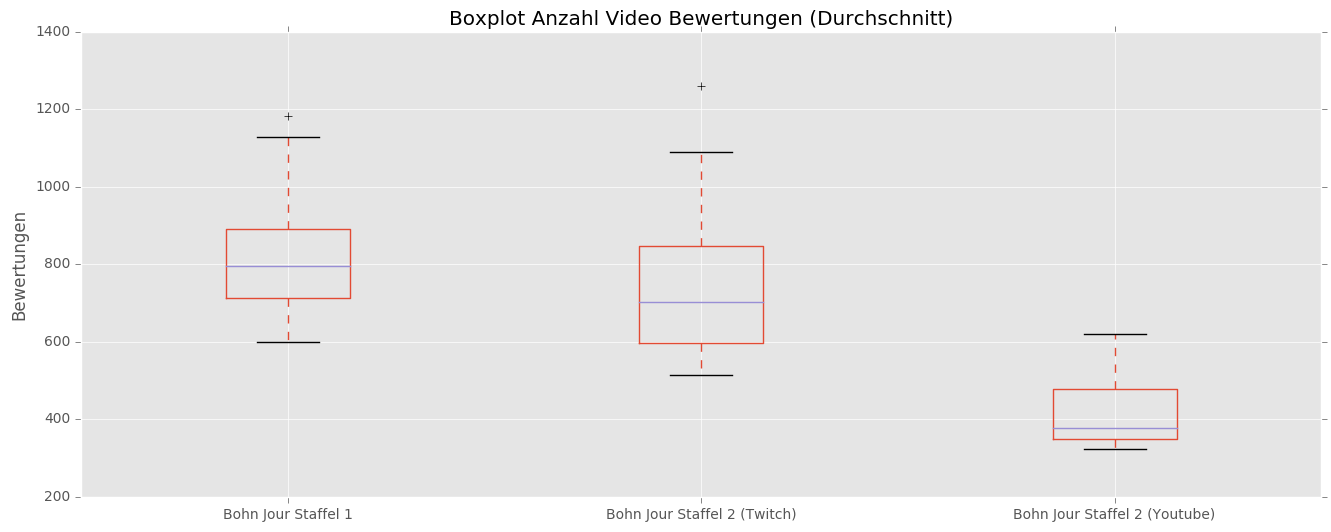

In [27]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Anzahl Video Bewertungen (Durchschnitt)')
plot.set_ylabel('Bewertungen')

plot

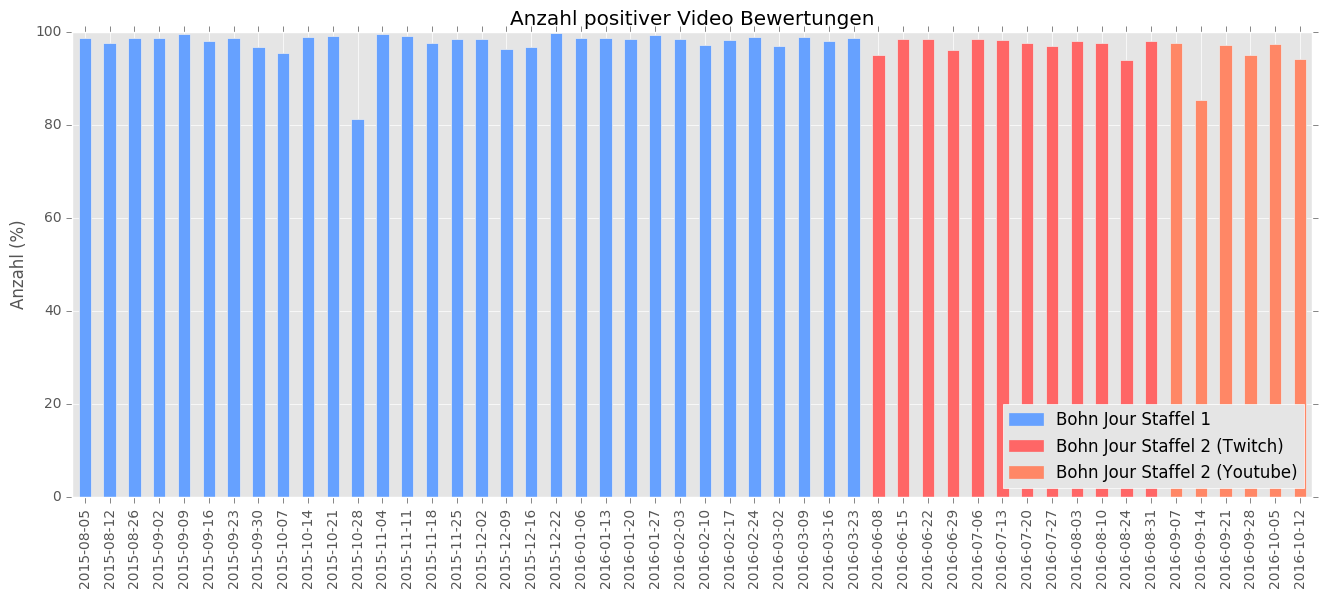

In [28]:
plot = data[['video_ratings_ratio_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl positiver Video Bewertungen')
plot.set_ylabel('Anzahl (%)')

plot.legend(loc=4, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

## Video Kommentare

- __Gesamte Kommentare__: Die Summe der Kommentare aller Video Teile
- __Durchschnittliche Kommentare__: Das arithmetische Mittel der Kommentare aus allen Video Teilen

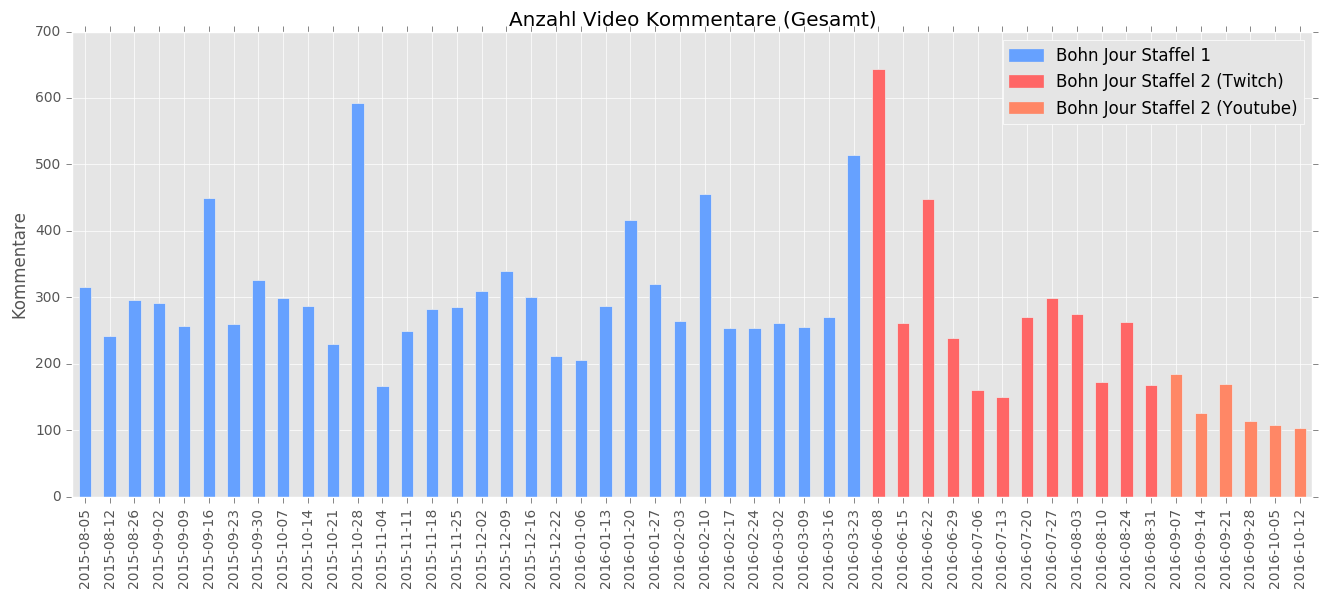

In [29]:
plot = data[['video_comments_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Kommentare (Gesamt)')
plot.set_ylabel('Kommentare')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

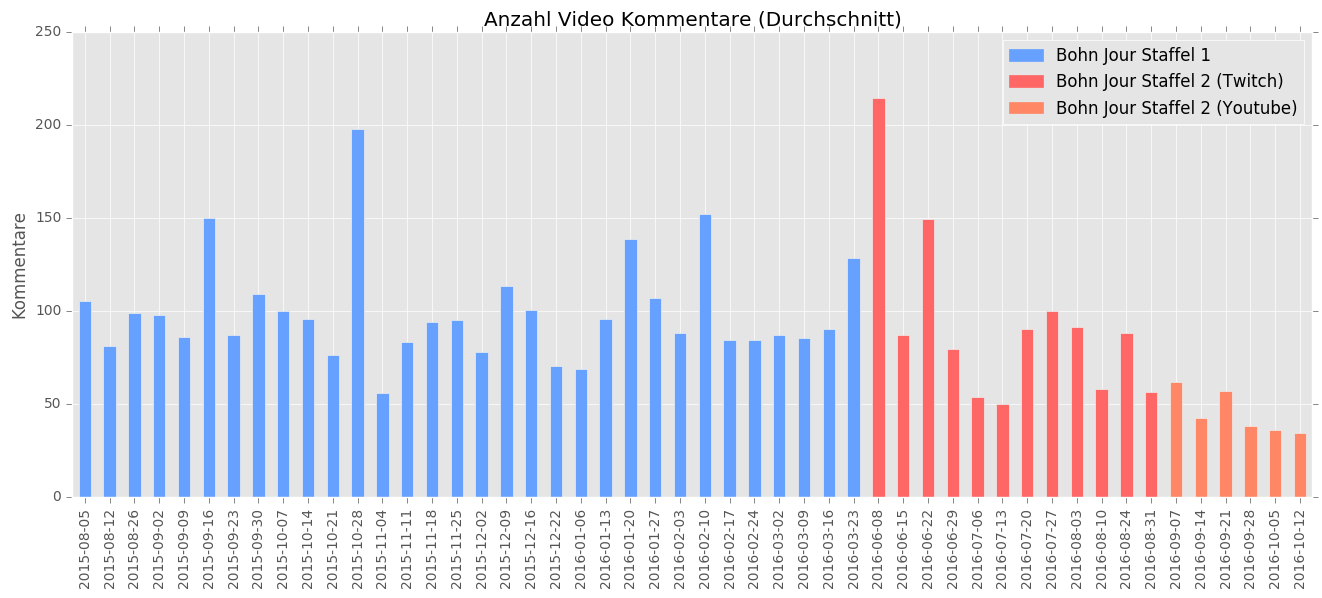

In [30]:
plot = data[['video_comments_mean']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Kommentare (Durchschnitt)')
plot.set_ylabel('Kommentare')

plot.legend(loc=0, handles=[bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend])

plot

In [31]:
subDataSeason1 = dataSeason1['video_comments_mean'].to_frame('Bohn Jour Staffel 1')
subDataSeason2Twitch = dataSeason2Twitch['video_comments_mean'].to_frame('Bohn Jour Staffel 2 (Twitch)')
subDataSeason2Youtube = dataSeason2Youtube['video_comments_mean'].to_frame('Bohn Jour Staffel 2 (Youtube)')

joinedData = subDataSeason1.join(subDataSeason2Twitch, how='outer').join(subDataSeason2Youtube, how='outer')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,6.000000
mean,99.354167,92.972222,44.722222
std,28.094080,46.945371,11.595817
min,55.666667,50.000000,34.333333
25%,84.333333,57.250000,36.250000
50%,94.500000,87.333333,40.000000
75%,105.416667,93.416667,53.000000
max,197.666667,214.333333,61.666667


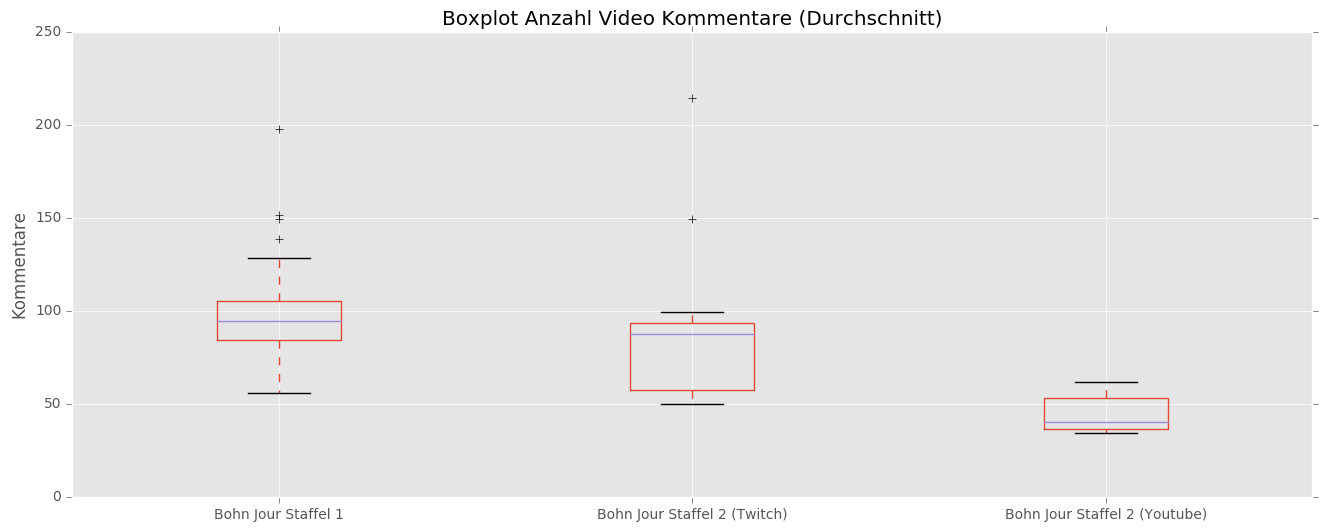

In [32]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Anzahl Video Kommentare (Durchschnitt)')
plot.set_ylabel('Kommentare')

plot